# Buckling Strength ML: Final Notebook (3 Experiments)

This notebook is a cleaned, end-to-end version of the 3-experiment workflow.
It includes data loading, cleaning, EDA, baseline and tuned models, post-model
EDA, feature importance, ratio diagnostics, and final conclusions.


## 1) Load data and drop units row
Short note: we load the Excel sheet and remove the units row before analysis.


In [1]:
import pandas as pd
from pathlib import Path
import pandas as pd
import numpy as np
import re

ROOT = Path(".").resolve()
DATA_PATH = ROOT / "data" / "data.xlsx"
#DATA_PATH = ROOT / "data.xlsx" # Use this line if data.xlsx is directly under ROOT, e.g for COLAB
SHEET_NAME = "Swati (Beam with hole)"

# Update if your file path differs
#data_path = "data.xlsx"

try:
    xls = pd.ExcelFile(DATA_PATH)
    sheet_name = xls.sheet_names[0]
    df_raw = pd.read_excel(xls, sheet_name=sheet_name, header=0)
except Exception as e:
    print(f"Failed to load Excel file at {DATA_PATH}: {e}")
    print("Please provide the exact sheet name and confirm the file path.")
    raise

print("Loaded sheet:", sheet_name)
print("Raw shape:", df_raw.shape)

if len(df_raw) > 1:
    print("Units row preview (raw row 2):")
    display(df_raw.iloc[[0]])
    df = df_raw.drop(index=0).reset_index(drop=True)
else:
    df = df_raw.copy()

print("Shape after dropping units row:", df.shape)
print("First 3 rows:")
display(df.head(3))
print("Column count:", len(df.columns))


Loaded sheet: Swati (Beam with hole)
Raw shape: (494, 33)
Units row preview (raw row 2):


,SL. No,JOURNAL TITLE,SPECIMEN,SHAPE CODE,Boundary condition,Loading condition,Fy,Fu,E,ν,...,Number Of Holes in Channel,Distance from top to centre of first hole Y,Distance from left to centre of first hole X,Centre to centre distance between adjesent holes in X direction Sx,Ultimate Buckiling Strength (Mtest),Ultimate Buckiling Strength (MFEM),Failure Mode,AISI,Eurocode 3,AS/NZS
0,Units,NaN,NaN,NaN,NaN,NaN,Mpa,Mpa,Mpa,NaN,...,Nos,mm,mm,mm,KN,KN,NaN,KN,KN,KN


Shape after dropping units row: (493, 33)
First 3 rows:


,SL. No,JOURNAL TITLE,SPECIMEN,SHAPE CODE,Boundary condition,Loading condition,Fy,Fu,E,ν,...,Number Of Holes in Channel,Distance from top to centre of first hole Y,Distance from left to centre of first hole X,Centre to centre distance between adjesent holes in X direction Sx,Ultimate Buckiling Strength (Mtest),Ultimate Buckiling Strength (MFEM),Failure Mode,AISI,Eurocode 3,AS/NZS
0,1,Moen et al. 2013,NH-1.1,C,Pinned and roller,four point loading,380,437.0,203500,0.3,...,NaN,NaN,NaN,NaN,12.6,10.6,Distortional and local,10.6,NaN,NaN
1,2,Moen et al. 2013,NH-1.2,C,Pinned and roller,four point loading,363,417.45,203500,0.3,...,NaN,NaN,NaN,NaN,12.6,10.6,Distortional and local,ˉ,NaN,NaN
2,3,Moen et al. 2013,NH-2.1,C,Pinned and roller,four point loading,364,418.6,203500,0.3,...,NaN,NaN,NaN,NaN,12.5,10.5,Distortional and local,10.5,NaN,NaN


Column count: 33


## 2) Cleaning and missingness checks
We normalize missing markers, standardize hole shape, and check missingness.


In [2]:
import pandas as pd

df_clean = df.copy()

# Normalize known missing markers
na_markers = ["NC", "N/C", "NA", "N/A", "-", "--", "—", "?", "", "nan", "NaN"]
df_clean = df_clean.replace(na_markers, pd.NA)

# Detect and normalize HOLE SHAPE
hole_shape_col = next((c for c in df_clean.columns if "hole shape" in c.lower()), None)
if hole_shape_col is None:
    print("Could not find HOLE SHAPE column. Columns available:")
    print(list(df_clean.columns))
else:
    hole_shape_raw = (
        df_clean[hole_shape_col]
        .astype(str)
        .str.strip()
        .str.lower()
        .replace({"nan": pd.NA, "none": "no hole", "nohole": "no hole", "no holes": "no hole", "solid": "no hole"})
    )
    shape_map = {
        "c": "circular", "circle": "circular", "circular": "circular",
        "r": "rectangular", "rect": "rectangular", "rectangle": "rectangular", "rectangular": "rectangular",
        "s": "square", "sq": "square", "square": "square",
        "slot": "slot", "slotted": "slot", "elongated": "elongated",
    }
    df_clean[hole_shape_col] = hole_shape_raw.replace(shape_map)
    print("HOLE SHAPE value counts (normalized):")
    display(df_clean[hole_shape_col].value_counts(dropna=False))

# Coerce numeric columns with a simple heuristic
def coerce_numeric(series, min_numeric_ratio=0.7):
    if series.dtype != object:
        return pd.to_numeric(series, errors="coerce"), True
    s_str = series.astype(str).str.strip().replace({"": pd.NA, "nan": pd.NA, "NaN": pd.NA})
    s_num = pd.to_numeric(s_str, errors="coerce")
    denom = s_str.notna().sum()
    if denom == 0:
        return series, False
    ratio = s_num.notna().sum() / denom
    if ratio >= min_numeric_ratio:
        return s_num, True
    return series, False

numeric_cols = []
for c in df_clean.columns:
    coerced, is_num = coerce_numeric(df_clean[c])
    if is_num:
        df_clean[c] = coerced
        numeric_cols.append(c)

print(f"Numeric columns detected: {len(numeric_cols)} / {df_clean.shape[1]}")

# Missingness table (top 15)
missingness = df_clean.isna().mean().sort_values(ascending=False)
display(missingness.to_frame("missing_frac").head(15))

# Hole-related columns by Excel positions U–AA
def excel_col_to_index(col):
    col = col.upper()
    idx = 0
    for ch in col:
        idx = idx * 26 + (ord(ch) - ord('A') + 1)
    return idx - 1

hole_start = excel_col_to_index("U")
hole_end = excel_col_to_index("AA")
hole_cols = [df_clean.columns[i] for i in range(hole_start, hole_end + 1) if i < df_clean.shape[1]]
print(f"Hole-related columns (U–AA): {hole_cols}")

if hole_shape_col and hole_cols:
    missing_by_shape = (
        df_clean.groupby(hole_shape_col, dropna=False)[hole_cols]
        .apply(lambda g: g.isna().mean().round(3))
    )
    print("Missingness by HOLE SHAPE (hole-related columns):")
    display(missing_by_shape)

    no_hole_mask = df_clean[hole_shape_col] == "no hole"
    if no_hole_mask.any():
        no_hole_vs_hole = pd.DataFrame({
            "no_hole_missing": df_clean.loc[no_hole_mask, hole_cols].isna().mean().round(3),
            "has_hole_missing": df_clean.loc[~no_hole_mask, hole_cols].isna().mean().round(3),
        })
        print("No-hole vs has-hole missingness (hole-related columns):")
        display(no_hole_vs_hole)


HOLE SHAPE value counts (normalized):


/var/folders/2r/65b3v1496498f35zwrwmt7900000gn/T/ipykernel_24038/1967206306.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean = df_clean.replace(na_markers, pd.NA)


HOLE SHAPE
elongated      204
rectangular    118
square         109
no hole         34
circular        28
Name: count, dtype: int64

Numeric columns detected: 26 / 33


,missing_frac
AS/NZS,1.000000
Eurocode 3,1.000000
Ultimate Buckiling Strength (Mtest),0.701826
AISI,0.675456
q,0.673428
r hole,0.529412
Centre to centre distance between adjesent holes in X direction Sx,0.484787
Failure Mode,0.267748
Ultimate Buckiling Strength (MFEM),0.172414
h hole,0.125761


Hole-related columns (U–AA): ['l hole', 'h hole', 'r hole', 'Number Of Holes in Channel ', 'Distance from top to centre of first hole Y   ', 'Distance from left  to centre of first hole X', 'Centre to centre distance between adjesent holes in X direction  Sx']
Missingness by HOLE SHAPE (hole-related columns):


,l hole,h hole,r hole,Number Of Holes in Channel,Distance from top to centre of first hole Y,Distance from left to centre of first hole X,Centre to centre distance between adjesent holes in X direction Sx
HOLE SHAPE,,,,,,,
circular,1.0,1.0,0.0,0.0,0.000,0.0,0.536
elongated,0.0,0.0,0.0,0.0,0.000,0.0,0.647
no hole,1.0,1.0,1.0,1.0,0.559,1.0,1.000
rectangular,0.0,0.0,1.0,0.0,0.000,0.0,0.186
square,0.0,0.0,1.0,0.0,0.000,0.0,0.330


No-hole vs has-hole missingness (hole-related columns):


,no_hole_missing,has_hole_missing
l hole,1.000,0.061
h hole,1.000,0.061
r hole,1.000,0.495
Number Of Holes in Channel,1.000,0.000
Distance from top to centre of first hole Y,0.559,0.000
Distance from left to centre of first hole X,1.000,0.000
Centre to centre distance between adjesent holes in X direction Sx,1.000,0.447


## 3) Pre-model EDA
Targets, correlations, and feature relationships.


MTEST non-null: 147
MFEM non-null: 408
Combined non-null: 492


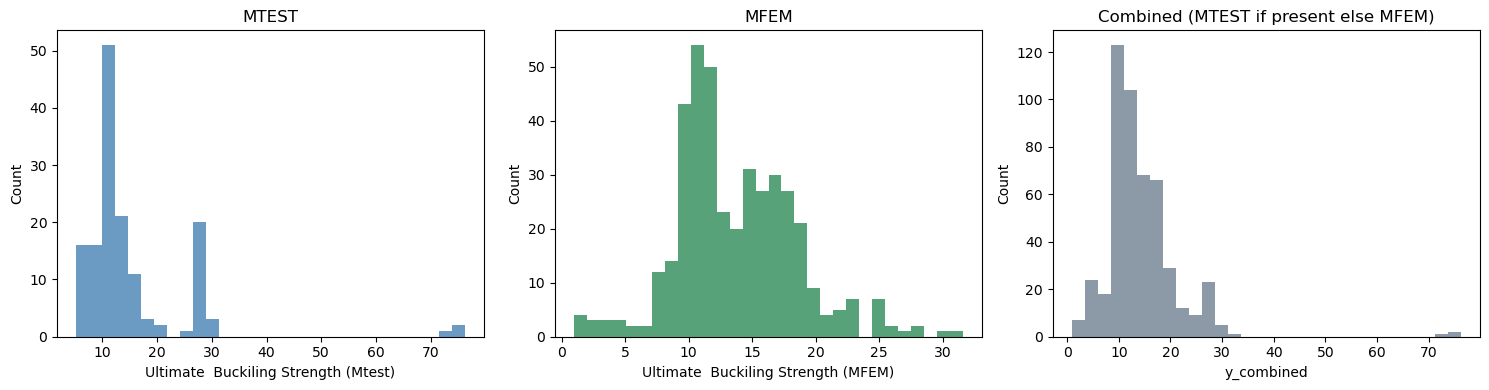

Numeric feature columns used for EDA: 19


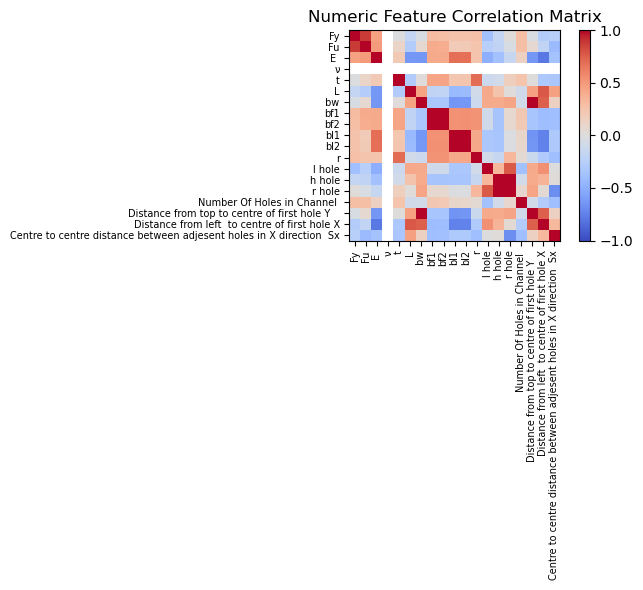

Top correlations for MTEST:


/opt/anaconda3/envs/soccermatics/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/soccermatics/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,corr
t,0.911722
Number Of Holes in Channel,0.640874
Distance from top to centre of first hole Y,0.488150
bw,0.484426
r,0.385589
bf1,0.377944
bf2,0.373620
E,-0.360069
Centre to centre distance between adjesent holes in X direction Sx,-0.262423
L,-0.201594


Top correlations for MFEM:


,corr
r,0.750792
t,0.748885
Fu,0.532471
Fy,0.482453
bf1,0.390291
bf2,0.389500
Centre to centre distance between adjesent holes in X direction Sx,-0.335508
E,0.279288
L,-0.274076
r hole,0.272600


Top correlations for COMBINED:


,corr
t,0.819071
r,0.431327
Number Of Holes in Channel,0.412076
bf1,0.310628
bf2,0.303891
bw,0.303693
Distance from top to centre of first hole Y,0.302525
Centre to centre distance between adjesent holes in X direction Sx,-0.249614
Fu,0.230441
L,-0.226816


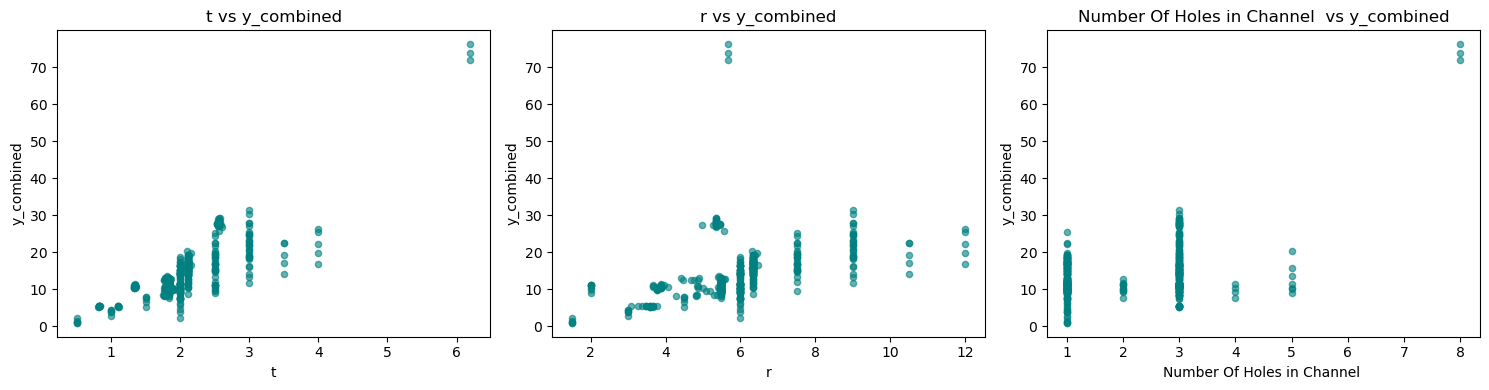

In [3]:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt

if "df_clean" not in globals():
    raise NameError("df_clean not found. Run Checkpoint 2 first.")

df_eda = df_clean.copy()

def find_col(df, key):
    return next((c for c in df.columns if key in c.lower()), None)

mtest_col = find_col(df_eda, "mtest")
mfem_col = find_col(df_eda, "mfem")
if mtest_col is None or mfem_col is None:
    raise ValueError("Could not find MTEST/MFEM columns. Check column names.")

df_eda["y_combined"] = df_eda[mtest_col].where(df_eda[mtest_col].notna(), df_eda[mfem_col])

print(f"MTEST non-null: {df_eda[mtest_col].notna().sum()}")
print(f"MFEM non-null: {df_eda[mfem_col].notna().sum()}")
print(f"Combined non-null: {df_eda['y_combined'].notna().sum()}")

# Target distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(df_eda[mtest_col].dropna(), bins=30, color="steelblue", alpha=0.8)
axes[0].set_title("MTEST")
axes[0].set_xlabel(mtest_col)
axes[0].set_ylabel("Count")

axes[1].hist(df_eda[mfem_col].dropna(), bins=30, color="seagreen", alpha=0.8)
axes[1].set_title("MFEM")
axes[1].set_xlabel(mfem_col)
axes[1].set_ylabel("Count")

axes[2].hist(df_eda["y_combined"].dropna(), bins=30, color="slategray", alpha=0.8)
axes[2].set_title("Combined (MTEST if present else MFEM)")
axes[2].set_xlabel("y_combined")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()

# Define feature columns for EDA (exclude A–F, AD–AG, q, and targets)
def excel_col_to_index(col):
    col = col.upper()
    idx = 0
    for ch in col:
        idx = idx * 26 + (ord(ch) - ord('A') + 1)
    return idx - 1

drop_cols = []
drop_cols += [df_eda.columns[i] for i in range(excel_col_to_index("A"), excel_col_to_index("F") + 1) if i < df_eda.shape[1]]
drop_cols += [df_eda.columns[i] for i in range(excel_col_to_index("AD"), excel_col_to_index("AG") + 1) if i < df_eda.shape[1]]
if "q" in df_eda.columns:
    drop_cols.append("q")

num_df = df_eda.select_dtypes(include="number").copy()
target_cols = [mtest_col, mfem_col, "y_combined"]
feature_cols = [c for c in num_df.columns if c not in target_cols and c not in drop_cols]

var = num_df[feature_cols].var(skipna=True)
feature_cols = [c for c in feature_cols if var.get(c, 0) > 0]

print(f"Numeric feature columns used for EDA: {len(feature_cols)}")

# Correlation matrix for numeric features
corr = num_df[feature_cols].corr()
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr.values, cmap="coolwarm", vmin=-1, vmax=1)
ax.set_xticks(range(len(feature_cols)))
ax.set_xticklabels(feature_cols, rotation=90, fontsize=7)
ax.set_yticks(range(len(feature_cols)))
ax.set_yticklabels(feature_cols, fontsize=7)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Numeric Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# Feature-to-target correlation ranking
targets = {"MTEST": mtest_col, "MFEM": mfem_col, "COMBINED": "y_combined"}
corr_tables = {}
for name, col in targets.items():
    if col in df_eda.columns:
        s = num_df[feature_cols].corrwith(df_eda[col]).dropna()
        s = s.reindex(s.abs().sort_values(ascending=False).index)
        corr_tables[name] = s
        print(f"Top correlations for {name}:")
        display(s.head(10).to_frame("corr"))

# Scatter plots for top 3 features vs combined (or MTEST)
scatter_target = "y_combined" if "y_combined" in df_eda.columns else mtest_col
scatter_source = "COMBINED" if "COMBINED" in corr_tables else "MTEST"
top_feats = corr_tables[scatter_source].dropna().head(3).index.tolist()

if top_feats:
    fig, axes = plt.subplots(1, len(top_feats), figsize=(5 * len(top_feats), 4), squeeze=False)
    for i, feat in enumerate(top_feats):
        ax = axes[0, i]
        ax.scatter(df_eda[feat], df_eda[scatter_target], alpha=0.6, s=20, color="teal")
        ax.set_xlabel(feat)
        ax.set_ylabel(scatter_target)
        ax.set_title(f"{feat} vs {scatter_target}")
    plt.tight_layout()
    plt.show()


## 4) Correlation heatmap (annotated)
Readable numeric correlation matrix with cell values.


Excluded constant numeric columns from correlation matrix: ['ν']
Correlation matrix size: 18x18


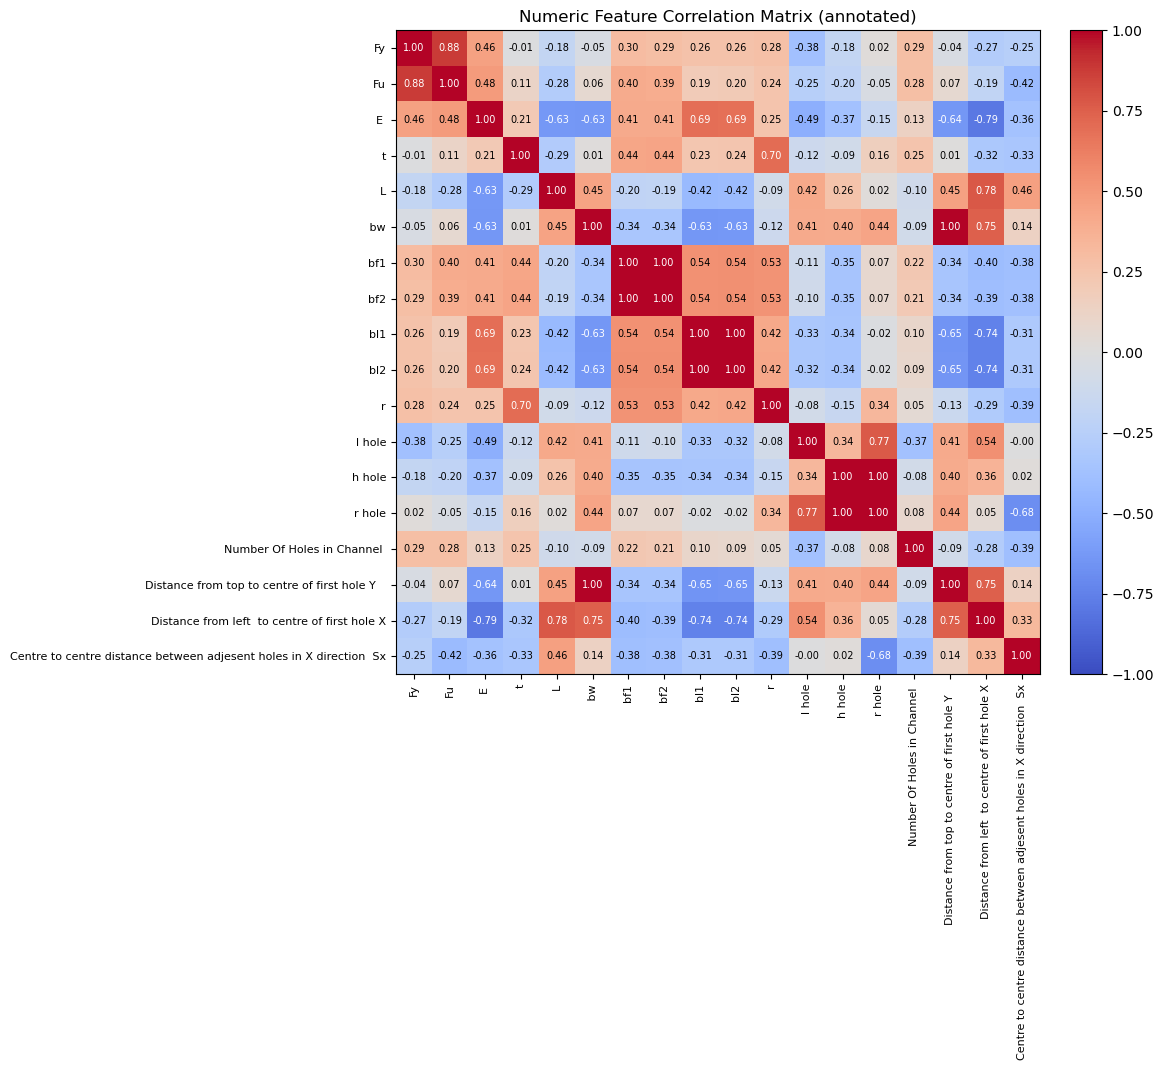

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# This cell rebuilds the numeric feature list used only for the correlation matrix:
# - Excludes identifier columns (A–F), standards (AD–AG), q, and target columns.
# - Drops constant/zero-variance columns (e.g., nu/nhu if constant).
# - Plots a larger annotated heatmap. df_clean is not modified.

if "df_clean" not in globals():
    raise NameError("df_clean not found. Run Checkpoint 2 first.")

def find_col(df, key):
    return next((c for c in df.columns if key in c.lower()), None)

def excel_col_to_index(col):
    col = col.upper()
    idx = 0
    for ch in col:
        idx = idx * 26 + (ord(ch) - ord('A') + 1)
    return idx - 1

mtest_col = find_col(df_clean, "mtest")
mfem_col = find_col(df_clean, "mfem")

num_df = df_clean.select_dtypes(include="number").copy()

# Exclude A–F, AD–AG, q, and targets from correlation matrix
drop_cols = []
drop_cols += [df_clean.columns[i] for i in range(excel_col_to_index("A"), excel_col_to_index("F") + 1) if i < df_clean.shape[1]]
drop_cols += [df_clean.columns[i] for i in range(excel_col_to_index("AD"), excel_col_to_index("AG") + 1) if i < df_clean.shape[1]]
if "q" in df_clean.columns:
    drop_cols.append("q")

feature_cols = [c for c in num_df.columns if c not in drop_cols and c not in {mtest_col, mfem_col}]

# Drop constant/zero-variance columns (for corr matrix only)
zero_var = [c for c in feature_cols if num_df[c].dropna().nunique() <= 1]
feature_cols = [c for c in feature_cols if c not in zero_var]

print("Excluded constant numeric columns from correlation matrix:", zero_var)

if not feature_cols:
    raise ValueError("No numeric feature columns found after filtering.")

corr = num_df[feature_cols].corr()
n = len(feature_cols)
print(f"Correlation matrix size: {n}x{n}")

# Larger annotated heatmap
fig_w = max(12, 0.6 * n)
fig_h = max(10, 0.6 * n)
fig, ax = plt.subplots(figsize=(fig_w, fig_h))
im = ax.imshow(corr.values, cmap="coolwarm", vmin=-1, vmax=1)

ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(feature_cols, rotation=90, fontsize=8)
ax.set_yticklabels(feature_cols, fontsize=8)

for i in range(n):
    for j in range(n):
        val = corr.values[i, j]
        label = "" if np.isnan(val) else f"{val:.2f}"
        color = "white" if not np.isnan(val) and abs(val) >= 0.6 else "black"
        ax.text(j, i, label, ha="center", va="center", fontsize=7, color=color)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Numeric Feature Correlation Matrix (annotated)")
plt.tight_layout()
plt.show()


## 5) Drop constant Poisson ratio (nu)
Remove constant nu column from features if present.


In [5]:
# Identify constant numeric columns and drop the 'nhu/nu/ν' column if present.
if "df_clean" not in globals():
    raise NameError("df_clean not found. Run Checkpoint 2 first.")

num_df = df_clean.select_dtypes(include="number")

constant_cols = {}
for c in num_df.columns:
    uniq = num_df[c].dropna().unique()
    if len(uniq) <= 1:
        constant_cols[c] = uniq[0] if len(uniq) == 1 else None

print("Constant numeric columns (name -> value):")
print(constant_cols)

nu_symbol = "\u03bd"  # Greek nu
candidate_names = { "nhu", "nu", nu_symbol }

drop_cols = [c for c in constant_cols.keys() if c.strip().lower() in candidate_names or c.strip() == nu_symbol]
if drop_cols:
    df_clean = df_clean.drop(columns=drop_cols)
    print(f"Dropped column(s): {drop_cols}")
else:
    print("No constant 'nhu/nu/ν' column found; nothing dropped.")


Constant numeric columns (name -> value):
{'ν': np.float64(0.3), 'Eurocode 3': None, 'AS/NZS': None}
Dropped column(s): ['ν']


## 6) Minimal feature engineering
Create bf_avg and bl_avg, drop bf1/bf2 and bl1/bl2.


Created columns: ['bf_avg', 'bl_avg']
Dropped columns: ['bf1', 'bf2', 'bl1', 'bl2']


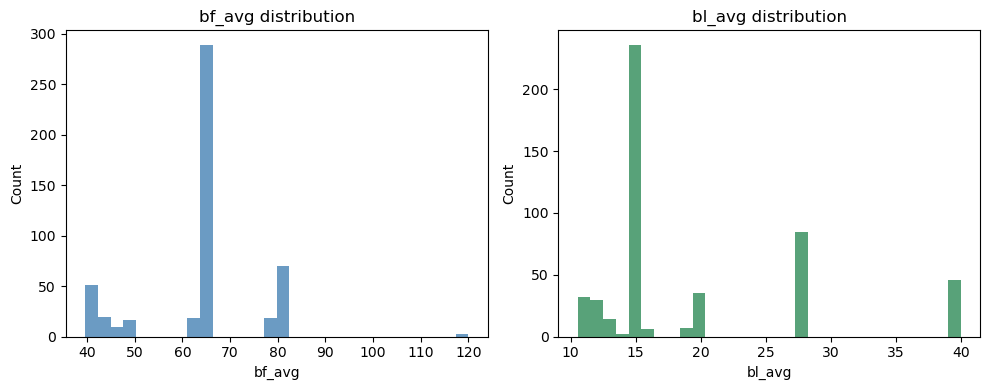

Correlation with Ultimate  Buckiling Strength (Mtest):
bf_avg    0.375953
bl_avg   -0.063086
dtype: float64
Correlation with Ultimate  Buckiling Strength (MFEM):
bf_avg    0.389920
bl_avg    0.224469
dtype: float64
Correlation with y_combined:
bf_avg    0.307310
bl_avg    0.056762
dtype: float64


In [6]:
# Checkpoint 4: minimal feature engineering.
# Create bf_avg and bl_avg as simple averages, drop bf1/bf2 and bl1/bl2,
# then show distributions and correlations with targets.
import matplotlib.pyplot as plt

if "df_clean" not in globals():
    raise NameError("df_clean not found. Run Checkpoint 2 first.")

def norm_name(c):
    return "".join(str(c).split()).lower()

def find_col_by_norm(df, target):
    return next((c for c in df.columns if norm_name(c) == target), None)

bf1_col = find_col_by_norm(df_clean, "bf1")
bf2_col = find_col_by_norm(df_clean, "bf2")
bl1_col = find_col_by_norm(df_clean, "bl1")
bl2_col = find_col_by_norm(df_clean, "bl2")

missing_pairs = [name for name, col in [("bf1", bf1_col), ("bf2", bf2_col), ("bl1", bl1_col), ("bl2", bl2_col)] if col is None]
if missing_pairs:
    print("Missing expected columns:", missing_pairs)

if bf1_col and bf2_col:
    df_clean["bf_avg"] = df_clean[[bf1_col, bf2_col]].mean(axis=1)
if bl1_col and bl2_col:
    df_clean["bl_avg"] = df_clean[[bl1_col, bl2_col]].mean(axis=1)

drop_cols = [c for c in [bf1_col, bf2_col, bl1_col, bl2_col] if c is not None]
if drop_cols:
    df_clean = df_clean.drop(columns=drop_cols)

print("Created columns:", [c for c in ["bf_avg", "bl_avg"] if c in df_clean.columns])
print("Dropped columns:", drop_cols)

# Distributions
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
if "bf_avg" in df_clean.columns:
    axes[0].hist(df_clean["bf_avg"].dropna(), bins=30, color="steelblue", alpha=0.8)
    axes[0].set_title("bf_avg distribution")
    axes[0].set_xlabel("bf_avg")
    axes[0].set_ylabel("Count")
else:
    axes[0].axis("off")

if "bl_avg" in df_clean.columns:
    axes[1].hist(df_clean["bl_avg"].dropna(), bins=30, color="seagreen", alpha=0.8)
    axes[1].set_title("bl_avg distribution")
    axes[1].set_xlabel("bl_avg")
    axes[1].set_ylabel("Count")
else:
    axes[1].axis("off")

plt.tight_layout()
plt.show()

# Correlation with targets
def find_col(df, key):
    return next((c for c in df.columns if key in c.lower()), None)

mtest_col = find_col(df_clean, "mtest")
mfem_col = find_col(df_clean, "mfem")
if mtest_col and mfem_col:
    df_clean["y_combined"] = df_clean[mtest_col].where(df_clean[mtest_col].notna(), df_clean[mfem_col])

for target in [mtest_col, mfem_col, "y_combined"]:
    if target in df_clean.columns:
        corr = df_clean[["bf_avg", "bl_avg"]].corrwith(df_clean[target])
        print(f"Correlation with {target}:")
        print(corr)


## 7) Define experiments and clean targets
Coerce targets to numeric and report experiment sizes.


In [7]:
# Debug/verify targets: find non-numeric entries, coerce to numeric, recompute experiment sizes.
if "df_clean" not in globals():
    raise NameError("df_clean not found. Run prior checkpoints first.")

def find_col(df, key):
    return next((c for c in df.columns if key in c.lower()), None)

mtest_col = find_col(df_clean, "mtest")
mfem_col = find_col(df_clean, "mfem")
if mtest_col is None or mfem_col is None:
    raise ValueError("Could not find MTEST/MFEM columns. Check column names.")

for col in [mtest_col, mfem_col]:
    s = df_clean[col]
    s_num = pd.to_numeric(s, errors="coerce")
    non_numeric = s[s.notna() & s_num.isna()]
    print(f"{col} non-numeric count: {non_numeric.shape[0]}")
    if non_numeric.shape[0] > 0:
        print(f"{col} non-numeric examples: {list(non_numeric.unique())[:5]}")
    # Coerce in-place so targets are truly numeric
    df_clean[col] = s_num

# Recompute experiment sizes
df_e1 = df_clean[df_clean[mtest_col].notna() | df_clean[mfem_col].notna()].copy()
df_e1["y"] = df_e1[mtest_col].where(df_e1[mtest_col].notna(), df_e1[mfem_col])

df_e2 = df_clean[df_clean[mfem_col].notna()].copy()
df_e2["y"] = df_e2[mfem_col]

df_e3 = df_clean[df_clean[mtest_col].notna()].copy()
df_e3["y"] = df_e3[mtest_col]

overlap_n = (df_clean[mtest_col].notna() & df_clean[mfem_col].notna()).sum()

print(f"E1 (combined) rows: {df_e1.shape[0]}")
print(f"E2 (MFEM-only) rows: {df_e2.shape[0]}")
print(f"E3 (MTEST-only) rows: {df_e3.shape[0]}")
print(f"Overlap (both MTEST & MFEM): {overlap_n}")


Ultimate  Buckiling Strength (Mtest) non-numeric count: 0
Ultimate  Buckiling Strength (MFEM) non-numeric count: 0
E1 (combined) rows: 492
E2 (MFEM-only) rows: 408
E3 (MTEST-only) rows: 147
Overlap (both MTEST & MFEM): 63


## 8) Leakage-safe grouping
Create geometry_signature and inspect GroupKFold splits.


In [8]:
# Checkpoint 6: leakage-safe splitting using geometry_signature + GroupKFold.
# We build geometry_signature from cleaned feature columns (no IDs, no targets),
# then report group counts and fold sizes for E1.

import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold

if "df_clean" not in globals():
    raise NameError("df_clean not found. Run prior checkpoints first.")

def find_col(df, key):
    return next((c for c in df.columns if key in c.lower()), None)

def excel_col_to_index(col):
    col = col.upper()
    idx = 0
    for ch in col:
        idx = idx * 26 + (ord(ch) - ord('A') + 1)
    return idx - 1

mtest_col = find_col(df_clean, "mtest")
mfem_col = find_col(df_clean, "mfem")
if mtest_col is None or mfem_col is None:
    raise ValueError("Could not find MTEST/MFEM columns. Check column names.")

# Ensure experiment dataframes exist
if "df_e1" not in globals() or "df_e2" not in globals() or "df_e3" not in globals():
    df_e1 = df_clean[df_clean[mtest_col].notna() | df_clean[mfem_col].notna()].copy()
    df_e1["y"] = df_e1[mtest_col].where(df_e1[mtest_col].notna(), df_e1[mfem_col])

    df_e2 = df_clean[df_clean[mfem_col].notna()].copy()
    df_e2["y"] = df_e2[mfem_col]

    df_e3 = df_clean[df_clean[mtest_col].notna()].copy()
    df_e3["y"] = df_e3[mtest_col]

# Build feature list for geometry_signature
drop_cols = []
drop_cols += [df_clean.columns[i] for i in range(excel_col_to_index("A"), excel_col_to_index("F") + 1) if i < df_clean.shape[1]]
drop_cols += [df_clean.columns[i] for i in range(excel_col_to_index("AD"), excel_col_to_index("AG") + 1) if i < df_clean.shape[1]]
if "q" in df_clean.columns:
    drop_cols.append("q")

extra_drop = {mtest_col, mfem_col, "y", "y_combined", "geometry_signature"}
feature_cols = [c for c in df_clean.columns if c not in drop_cols and c not in extra_drop]

print(f"Feature cols for geometry_signature: {len(feature_cols)}")

# Build signature with sentinel fill for NaNs
sig_df = df_clean[feature_cols].copy()
for c in sig_df.columns:
    if pd.api.types.is_numeric_dtype(sig_df[c]):
        sig_df[c] = sig_df[c].fillna(-999999)
    else:
        sig_df[c] = sig_df[c].fillna("MISSING").astype(str)

geometry_signature = pd.util.hash_pandas_object(sig_df, index=False).astype("int64")
df_clean["geometry_signature"] = geometry_signature

# Attach to experiments
df_e1["geometry_signature"] = df_clean.loc[df_e1.index, "geometry_signature"]
df_e2["geometry_signature"] = df_clean.loc[df_e2.index, "geometry_signature"]
df_e3["geometry_signature"] = df_clean.loc[df_e3.index, "geometry_signature"]

def group_summary(name, d):
    uniq = d["geometry_signature"].nunique()
    avg = d.shape[0] / uniq if uniq else np.nan
    print(f"{name}: rows={d.shape[0]}, unique_groups={uniq}, avg_group_size={avg:.3f}")

group_summary("E1", df_e1)
group_summary("E2", df_e2)
group_summary("E3", df_e3)

# GroupKFold sizes for E1
gkf = GroupKFold(n_splits=5)
groups = df_e1["geometry_signature"].to_numpy()
X_dummy = np.zeros(len(df_e1))

for fold, (tr, te) in enumerate(gkf.split(X_dummy, groups=groups), start=1):
    print(f"E1 Fold {fold}: train={len(tr)}, test={len(te)}")

# GroupKFold sizes for E2
gkf = GroupKFold(n_splits=5)
groups = df_e2["geometry_signature"].to_numpy()
X_dummy = np.zeros(len(df_e2))  
for fold, (tr, te) in enumerate(gkf.split(X_dummy, groups=groups), start=1):
    print(f"E2 Fold {fold}: train={len(tr)}, test={len(te)}")

# GroupKFold sizes for E3
gkf = GroupKFold(n_splits=5)
groups = df_e3["geometry_signature"].to_numpy()
X_dummy = np.zeros(len(df_e3))  
for fold, (tr, te) in enumerate(gkf.split(X_dummy, groups=groups), start=1):
    print(f"E3 Fold {fold}: train={len(tr)}, test={len(te)}")


Feature cols for geometry_signature: 20
E1: rows=492, unique_groups=332, avg_group_size=1.482
E2: rows=408, unique_groups=254, avg_group_size=1.606
E3: rows=147, unique_groups=141, avg_group_size=1.043
E1 Fold 1: train=393, test=99
E1 Fold 2: train=393, test=99
E1 Fold 3: train=394, test=98
E1 Fold 4: train=394, test=98
E1 Fold 5: train=394, test=98
E2 Fold 1: train=326, test=82
E2 Fold 2: train=326, test=82
E2 Fold 3: train=326, test=82
E2 Fold 4: train=327, test=81
E2 Fold 5: train=327, test=81
E3 Fold 1: train=117, test=30
E3 Fold 2: train=117, test=30
E3 Fold 3: train=118, test=29
E3 Fold 4: train=118, test=29
E3 Fold 5: train=118, test=29


## 9) Baseline models
Train baseline models with GroupKFold and store results.


In [9]:
# Checkpoint 7: build baseline pipelines + GroupKFold CV for E1/E2/E3.
# This uses name-based drop rules (A-F and AD-AG by column names) so shifts
# from earlier column drops do not leak standards columns into features.

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

if "df_clean" not in globals():
    raise NameError("df_clean not found. Run prior checkpoints first.")

def norm_col(name):
    return "".join(ch for ch in str(name).lower() if ch.isalnum())

def find_col(df, key):
    return next((c for c in df.columns if key in c.lower()), None)

# Make a working copy so we can safely coerce targets to numeric
df_work = df_clean.copy()

mtest_col = find_col(df_work, "mtest")
mfem_col = find_col(df_work, "mfem")
if mtest_col is None or mfem_col is None:
    raise ValueError("Could not find MTEST/MFEM columns. Check column names.")

df_work[mtest_col] = pd.to_numeric(df_work[mtest_col], errors="coerce")
df_work[mfem_col] = pd.to_numeric(df_work[mfem_col], errors="coerce")

# Name-based drop list for A-F and AD-AG columns (robust to column shifts)
drop_keys = {
    "slno", "journaltitle", "specimen", "shapecode", "boundarycondition", "loadingcondition",
    "failuremode", "aisi", "eurocode3", "asnzs",
    "q",
}
drop_cols = [c for c in df_work.columns if norm_col(c) in drop_keys]

# Feature columns: everything except drop_cols, targets, and temp fields
exclude = set(drop_cols + [mtest_col, mfem_col, "y", "y_combined", "geometry_signature"])
feature_cols = [c for c in df_work.columns if c not in exclude]

# Split numeric vs categorical, and drop constant or all-missing columns
cat_cols = [c for c in feature_cols if df_work[c].dtype == object]
num_cols = [c for c in feature_cols if c not in cat_cols]

num_cols = [c for c in num_cols if df_work[c].dropna().nunique() > 1]
cat_cols = [c for c in cat_cols if df_work[c].dropna().nunique() > 1]

feature_cols = num_cols + cat_cols

print(f"Feature columns used: {len(feature_cols)}")
print(f"Numeric: {len(num_cols)}, Categorical: {len(cat_cols)}")

# Recompute geometry_signature based on final feature set
sig_df = df_work[feature_cols].copy()
for c in sig_df.columns:
    if pd.api.types.is_numeric_dtype(sig_df[c]):
        sig_df[c] = sig_df[c].fillna(-999999)
    else:
        sig_df[c] = sig_df[c].fillna("MISSING").astype(str)

df_work["geometry_signature"] = pd.util.hash_pandas_object(sig_df, index=False).astype("int64")

# Rebuild experiments
df_e1 = df_work[df_work[mtest_col].notna() | df_work[mfem_col].notna()].copy()
df_e1["y"] = df_e1[mtest_col].where(df_e1[mtest_col].notna(), df_e1[mfem_col])

df_e2 = df_work[df_work[mfem_col].notna()].copy()
df_e2["y"] = df_e2[mfem_col]

df_e3 = df_work[df_work[mtest_col].notna()].copy()
df_e3["y"] = df_e3[mtest_col]

# Preprocessor
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe),
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols),
])

# Models
models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001, max_iter=10000, random_state=0),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=0),
    "GradientBoosting": GradientBoostingRegressor(random_state=0),
}

model_families = {
    "Ridge": "linear",
    "Lasso": "linear",
    "RandomForest": "tree",
    "GradientBoosting": "tree",
}

def pearson_corr(y_true, y_pred):
    if len(y_true) < 2:
        return np.nan
    if np.std(y_true) == 0 or np.std(y_pred) == 0:
        return 0.0
    return float(np.corrcoef(y_true, y_pred)[0, 1])

scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": "neg_root_mean_squared_error",
    "r2": "r2",
    "pearson": make_scorer(pearson_corr),
}

results = []
fitted_models = {}

def run_experiment(d, exp_name):
    X = d[feature_cols]
    y = d["y"]
    groups = d["geometry_signature"]
    gkf = GroupKFold(n_splits=5)

    for model_name, model in models.items():
        pipe = Pipeline([("preprocess", preprocessor), ("model", model)])
        cv = cross_validate(pipe, X, y, cv=gkf, groups=groups, scoring=scoring, return_train_score=False)

        res = {
            "experiment": exp_name,
            "model": model_name,
            "model_family": model_families[model_name],
            "best_params": "default",
            "mae_mean": -cv["test_mae"].mean(),
            "mae_std": cv["test_mae"].std(),
            "rmse_mean": -cv["test_rmse"].mean(),
            "rmse_std": cv["test_rmse"].std(),
            "r2_mean": cv["test_r2"].mean(),
            "r2_std": cv["test_r2"].std(),
            "pearson_mean": cv["test_pearson"].mean(),
            "pearson_std": cv["test_pearson"].std(),
        }
        results.append(res)

        # Fit on full data for later analysis
        pipe.fit(X, y)
        fitted_models[(exp_name, model_name)] = pipe

run_experiment(df_e1, "E1_combined")
run_experiment(df_e2, "E2_mfem")
run_experiment(df_e3, "E3_mtest")

results_df = pd.DataFrame(results)
display(results_df.sort_values(["experiment", "model_family", "model"]).reset_index(drop=True))


Feature columns used: 17
Numeric: 16, Categorical: 1


/opt/anaconda3/envs/soccermatics/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.081e-01, tolerance: 7.296e-01
  model = cd_fast.enet_coordinate_descent(


,experiment,model,model_family,best_params,mae_mean,mae_std,rmse_mean,rmse_std,r2_mean,r2_std,pearson_mean,pearson_std
0,E1_combined,Lasso,linear,default,1.103518,0.204852,1.543373,0.438832,0.948185,0.022572,0.974622,0.011398
1,E1_combined,Ridge,linear,default,1.100033,0.201959,1.542826,0.437679,0.948285,0.022400,0.974657,0.011300
2,E1_combined,GradientBoosting,tree,default,0.947555,0.123209,1.384708,0.330252,0.955763,0.020980,0.978500,0.010952
3,E1_combined,RandomForest,tree,default,0.952416,0.167265,1.527113,0.309447,0.948927,0.019467,0.976224,0.011011
4,E2_mfem,Lasso,linear,default,1.079919,0.094366,1.547811,0.365742,0.881373,0.075074,0.943725,0.033453
5,E2_mfem,Ridge,linear,default,1.080402,0.092224,1.546870,0.359269,0.881839,0.073656,0.943818,0.033021
6,E2_mfem,GradientBoosting,tree,default,0.932335,0.127334,1.419927,0.402270,0.898378,0.072154,0.951221,0.033203
7,E2_mfem,RandomForest,tree,default,0.972771,0.155371,1.443062,0.370503,0.896425,0.070789,0.950219,0.033428
8,E3_mtest,Lasso,linear,default,0.833818,0.098806,1.189040,0.164621,0.983032,0.009006,0.992451,0.004438
9,E3_mtest,Ridge,linear,default,0.870956,0.071136,1.245879,0.142326,0.977171,0.018165,0.989776,0.008504


### Baseline summary
Best models and family comparison.


In [10]:
# This cell summarizes best models per experiment and compares linear vs tree families.
if "results_df" not in globals():
    raise NameError("results_df not found. Run Checkpoint 7 first.")

summary = results_df.copy()

# Best overall per experiment by MAE
best_overall = (
    summary.sort_values(["experiment", "mae_mean"])
    .groupby("experiment", as_index=False)
    .head(1)
    .loc[:, ["experiment", "model", "model_family", "mae_mean", "rmse_mean", "r2_mean", "pearson_mean"]]
)
print("Best model per experiment (by MAE):")
display(best_overall)

# Best per family and MAE gap (tree - linear)
best_family = (
    summary.sort_values(["experiment", "model_family", "mae_mean"])
    .groupby(["experiment", "model_family"], as_index=False)
    .head(1)
    .loc[:, ["experiment", "model_family", "model", "mae_mean", "rmse_mean"]]
)

pivot = best_family.pivot(index="experiment", columns="model_family", values="mae_mean")
pivot["tree_minus_linear_mae"] = pivot["tree"] - pivot["linear"]

print("MAE by model family (lower is better):")
display(pivot)


Best model per experiment (by MAE):


,experiment,model,model_family,mae_mean,rmse_mean,r2_mean,pearson_mean
3,E1_combined,GradientBoosting,tree,0.947555,1.384708,0.955763,0.978500
7,E2_mfem,GradientBoosting,tree,0.932335,1.419927,0.898378,0.951221
11,E3_mtest,GradientBoosting,tree,0.719744,1.326005,0.980698,0.992052


MAE by model family (lower is better):


model_family,linear,tree,tree_minus_linear_mae
experiment,,,
E1_combined,1.100033,0.947555,-0.152478
E2_mfem,1.079919,0.932335,-0.147584
E3_mtest,0.833818,0.719744,-0.114074


## 10) Save best models per family
Keep best linear and tree models for each experiment.


In [11]:
# Save best linear + best tree model per experiment (by MAE), plus fitted pipelines.
# This uses results_df and fitted_models from Checkpoint 7; it does not rerun CV.
if "results_df" not in globals():
    raise NameError("results_df not found. Run Checkpoint 7 first.")

best_by_family = (
    results_df.sort_values(["experiment", "model_family", "mae_mean"])
    .groupby(["experiment", "model_family"], as_index=False)
    .head(1)
    .loc[:, ["experiment", "model_family", "model", "mae_mean", "rmse_mean", "r2_mean", "pearson_mean"]]
)

# Attach fitted pipeline objects if available
model_objs = {}
if "fitted_models" in globals():
    for _, row in best_by_family.iterrows():
        exp = row["experiment"]
        fam = row["model_family"]
        name = row["model"]
        pipe = fitted_models.get((exp, name))
        model_objs.setdefault(exp, {})[fam] = {"model_name": name, "pipeline": pipe}

results_store = globals().get("results_store", {})
results_store["best_by_family"] = best_by_family.copy()
results_store["best_model_objects"] = model_objs
globals()["results_store"] = results_store

print("Stored best models per family in results_store['best_by_family'] and ['best_model_objects']")
display(best_by_family)


Stored best models per family in results_store['best_by_family'] and ['best_model_objects']


,experiment,model_family,model,mae_mean,rmse_mean,r2_mean,pearson_mean
0,E1_combined,linear,Ridge,1.100033,1.542826,0.948285,0.974657
3,E1_combined,tree,GradientBoosting,0.947555,1.384708,0.955763,0.978500
5,E2_mfem,linear,Lasso,1.079919,1.547811,0.881373,0.943725
7,E2_mfem,tree,GradientBoosting,0.932335,1.419927,0.898378,0.951221
9,E3_mtest,linear,Lasso,0.833818,1.189040,0.983032,0.992451
11,E3_mtest,tree,GradientBoosting,0.719744,1.326005,0.980698,0.992052


## 11) Hole shape coverage
Check missing shapes across experiments (slot is absent in E3).


In [12]:
# This cell verifies hole-shape coverage across E1/E2/E3 and flags missing shapes per experiment.
# It does NOT change df_clean; it only reports counts and missing categories.
import pandas as pd

if "df_clean" not in globals():
    raise NameError("df_clean not found. Run prior checkpoints first.")

def find_col(df, key):
    return next((c for c in df.columns if key in c.lower()), None)

hole_shape_col = find_col(df_clean, "hole shape")
if hole_shape_col is None:
    raise ValueError("HOLE SHAPE column not found.")

def normalize_shape(s):
    s = s.astype(str).str.strip().str.lower()
    s = s.replace({
        "nan": pd.NA,
        "none": "no hole",
        "nohole": "no hole",
        "no holes": "no hole",
        "solid": "no hole",
    })
    shape_map = {
        "c": "circular", "circle": "circular", "circular": "circular",
        "r": "rectangular", "rect": "rectangular", "rectangle": "rectangular", "rectangular": "rectangular",
        "s": "square", "sq": "square", "square": "square",
        "slot": "slot", "slotted": "slot", "elongated": "slot",
    }
    return s.replace(shape_map)

mtest_col = find_col(df_clean, "mtest")
mfem_col = find_col(df_clean, "mfem")
if mtest_col is None or mfem_col is None:
    raise ValueError("MTEST/MFEM columns not found.")

df_base = df_clean.copy()
df_base[mtest_col] = pd.to_numeric(df_base[mtest_col], errors="coerce")
df_base[mfem_col] = pd.to_numeric(df_base[mfem_col], errors="coerce")

exp_dfs = {
    "E1_combined": df_base[df_base[mtest_col].notna() | df_base[mfem_col].notna()],
    "E2_mfem": df_base[df_base[mfem_col].notna()],
    "E3_mtest": df_base[df_base[mtest_col].notna()],
}

counts = {}
for name, d in exp_dfs.items():
    shapes = normalize_shape(d[hole_shape_col])
    counts[name] = shapes.value_counts(dropna=False)

counts_df = pd.DataFrame(counts).fillna(0).astype(int)

all_shapes = counts_df.index.tolist()
missing = {name: [s for s in all_shapes if counts_df.loc[s, name] == 0] for name in counts_df.columns}

print("HOLE SHAPE counts by experiment:")
display(counts_df)
print("Missing shapes per experiment:")
print(missing)

results_store = globals().get("results_store", {})
results_store["hole_shape_coverage"] = {"counts": counts_df.copy(), "missing": missing}
globals()["results_store"] = results_store


HOLE SHAPE counts by experiment:


,E1_combined,E2_mfem,E3_mtest
HOLE SHAPE,,,
circular,28,14,28
no hole,34,18,27
rectangular,118,115,31
slot,204,204,0
square,108,57,61


Missing shapes per experiment:
{'E1_combined': [], 'E2_mfem': [], 'E3_mtest': ['slot']}


## 12) Tuned models (small search)
Run a small hyperparameter search to improve baseline.


In [13]:
# Checkpoint 8: small hyperparameter search (GroupKFold, leakage-safe).
# We rebuild the feature list (name-based drops), recompute geometry_signature,
# and run GridSearchCV for Ridge, Lasso, RandomForest, and GradientBoosting
# across E1/E2/E3. Best models + CV metrics are stored for later use.

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

if "df_clean" not in globals():
    raise NameError("df_clean not found. Run prior checkpoints first.")

def norm_col(name):
    return "".join(ch for ch in str(name).lower() if ch.isalnum())

def find_col(df, key):
    return next((c for c in df.columns if key in c.lower()), None)

def pearson_corr(y_true, y_pred):
    if len(y_true) < 2:
        return np.nan
    if np.std(y_true) == 0 or np.std(y_pred) == 0:
        return 0.0
    return float(np.corrcoef(y_true, y_pred)[0, 1])

# Prepare working df + targets
df_work = df_clean.copy()
mtest_col = find_col(df_work, "mtest")
mfem_col = find_col(df_work, "mfem")
if mtest_col is None or mfem_col is None:
    raise ValueError("Could not find MTEST/MFEM columns. Check column names.")

df_work[mtest_col] = pd.to_numeric(df_work[mtest_col], errors="coerce")
df_work[mfem_col] = pd.to_numeric(df_work[mfem_col], errors="coerce")

# Name-based drops (robust to column shifts)
drop_keys = {
    "slno", "journaltitle", "specimen", "shapecode",
    "boundarycondition", "loadingcondition",
    "failuremode", "aisi", "eurocode3", "asnzs",
    "q",
}
drop_cols = [c for c in df_work.columns if norm_col(c) in drop_keys]

exclude = set(drop_cols + [mtest_col, mfem_col, "y", "y_combined", "geometry_signature"])
feature_cols = [c for c in df_work.columns if c not in exclude]

# Split numeric vs categorical and drop constant/all-missing columns
cat_cols = [c for c in feature_cols if df_work[c].dtype == object]
num_cols = [c for c in feature_cols if c not in cat_cols]

num_cols = [c for c in num_cols if df_work[c].dropna().nunique() > 1]
cat_cols = [c for c in cat_cols if df_work[c].dropna().nunique() > 1]
feature_cols = num_cols + cat_cols

if not feature_cols:
    raise ValueError("No feature columns found after filtering.")

print(f"Feature columns used: {len(feature_cols)} (num={len(num_cols)}, cat={len(cat_cols)})")

# Build geometry_signature from feature columns
sig_df = df_work[feature_cols].copy()
for c in sig_df.columns:
    if pd.api.types.is_numeric_dtype(sig_df[c]):
        sig_df[c] = sig_df[c].fillna(-999999)
    else:
        sig_df[c] = sig_df[c].fillna("MISSING").astype(str)

df_work["geometry_signature"] = pd.util.hash_pandas_object(sig_df, index=False).astype("int64")

# Build experiments
df_e1 = df_work[df_work[mtest_col].notna() | df_work[mfem_col].notna()].copy()
df_e1["y"] = df_e1[mtest_col].where(df_e1[mtest_col].notna(), df_e1[mfem_col])

df_e2 = df_work[df_work[mfem_col].notna()].copy()
df_e2["y"] = df_e2[mfem_col]

df_e3 = df_work[df_work[mtest_col].notna()].copy()
df_e3["y"] = df_e3[mtest_col]

# Preprocessor
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe),
])

transformers = [("num", numeric_transformer, num_cols)]
if cat_cols:
    transformers.append(("cat", categorical_transformer, cat_cols))

preprocessor = ColumnTransformer(transformers)

# Models + small grids
model_grids = {
    "Ridge": (Ridge(), {"model__alpha": [0.1, 1.0, 10.0, 100.0]}),
    "Lasso": (Lasso(max_iter=20000, random_state=0), {"model__alpha": [0.0005, 0.001, 0.005, 0.01]}),
    "RandomForest": (
        RandomForestRegressor(n_estimators=200, random_state=0),
        {"model__max_depth": [None, 8, 16], "model__min_samples_leaf": [1, 2]}
    ),
    "GradientBoosting": (
        GradientBoostingRegressor(random_state=0),
        {"model__n_estimators": [200, 400], "model__learning_rate": [0.05, 0.1], "model__max_depth": [2, 3]}
    ),
}

model_families = {
    "Ridge": "linear",
    "Lasso": "linear",
    "RandomForest": "tree",
    "GradientBoosting": "tree",
}

scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": "neg_root_mean_squared_error",
    "r2": "r2",
    "pearson": make_scorer(pearson_corr),
}

results = []
tuned_models = {}

def run_search(d, exp_name):
    X = d[feature_cols]
    y = d["y"]
    groups = d["geometry_signature"]
    gkf = GroupKFold(n_splits=5)

    for model_name, (base_model, grid) in model_grids.items():
        pipe = Pipeline([("preprocess", preprocessor), ("model", base_model)])
        gs = GridSearchCV(
            pipe,
            param_grid=grid,
            cv=gkf,
            scoring=scoring,
            refit="mae",
            n_jobs=-1
        )
        gs.fit(X, y, groups=groups)

        best_idx = gs.best_index_
        cv = gs.cv_results_
        res = {
            "experiment": exp_name,
            "model": model_name,
            "model_family": model_families[model_name],
            "best_params": gs.best_params_,
            "mae_mean": -cv["mean_test_mae"][best_idx],
            "mae_std": cv["std_test_mae"][best_idx],
            "rmse_mean": -cv["mean_test_rmse"][best_idx],
            "rmse_std": cv["std_test_rmse"][best_idx],
            "r2_mean": cv["mean_test_r2"][best_idx],
            "r2_std": cv["std_test_r2"][best_idx],
            "pearson_mean": cv["mean_test_pearson"][best_idx],
            "pearson_std": cv["std_test_pearson"][best_idx],
        }
        results.append(res)
        tuned_models[(exp_name, model_name)] = gs.best_estimator_

run_search(df_e1, "E1_combined")
run_search(df_e2, "E2_mfem")
run_search(df_e3, "E3_mtest")

results_df_tuned = pd.DataFrame(results)
display(results_df_tuned.sort_values(["experiment", "model_family", "model"]).reset_index(drop=True))

results_store = globals().get("results_store", {})
results_store["tuned_cv"] = results_df_tuned.copy()
results_store["tuned_models"] = tuned_models
globals()["results_store"] = results_store


Feature columns used: 17 (num=16, cat=1)


/opt/anaconda3/envs/soccermatics/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.783e+00, tolerance: 7.296e-01
  model = cd_fast.enet_coordinate_descent(


,experiment,model,model_family,best_params,mae_mean,mae_std,rmse_mean,rmse_std,r2_mean,r2_std,pearson_mean,pearson_std
0,E1_combined,Lasso,linear,{'model__alpha': 0.005},1.101818,0.206000,1.543678,0.440517,0.948207,0.022580,0.974638,0.011384
1,E1_combined,Ridge,linear,{'model__alpha': 1.0},1.100033,0.201959,1.542826,0.437679,0.948285,0.022400,0.974657,0.011300
2,E1_combined,GradientBoosting,tree,"{'model__learning_rate': 0.1, 'model__max_dept...",0.887684,0.187213,1.416116,0.401553,0.949765,0.034976,0.974947,0.018203
3,E1_combined,RandomForest,tree,"{'model__max_depth': None, 'model__min_samples...",0.952416,0.167265,1.527113,0.309447,0.948927,0.019467,0.976224,0.011011
4,E2_mfem,Lasso,linear,{'model__alpha': 0.005},1.079984,0.091101,1.545754,0.359156,0.881980,0.073562,0.943867,0.033112
5,E2_mfem,Ridge,linear,{'model__alpha': 1.0},1.080402,0.092224,1.546870,0.359269,0.881839,0.073656,0.943818,0.033021
6,E2_mfem,GradientBoosting,tree,"{'model__learning_rate': 0.05, 'model__max_dep...",0.900836,0.109584,1.430668,0.383757,0.898720,0.067126,0.950942,0.030741
7,E2_mfem,RandomForest,tree,"{'model__max_depth': 16, 'model__min_samples_l...",0.971701,0.154459,1.440924,0.368943,0.896754,0.070440,0.950395,0.033228
8,E3_mtest,Lasso,linear,{'model__alpha': 0.01},0.801012,0.115599,1.139204,0.193641,0.984935,0.007865,0.993383,0.003874
9,E3_mtest,Ridge,linear,{'model__alpha': 0.1},0.843330,0.086228,1.204907,0.142596,0.981859,0.010745,0.991882,0.005268


### Baseline vs tuned comparison
Summarize MAE improvements.


In [14]:
# Compare baseline vs tuned results and store MAE improvements.
# This does not rerun any models; it only summarizes existing results.
import pandas as pd

baseline = globals().get("results_df", None)
tuned = globals().get("results_df_tuned", None)

if baseline is None:
    baseline = globals().get("results_store", {}).get("baseline_cv", None)
if tuned is None:
    tuned = globals().get("results_store", {}).get("tuned_cv", None)

if baseline is None or tuned is None:
    raise NameError("Missing baseline or tuned results. Run Checkpoints 7 and 8 first.")

def best_overall(df):
    return (
        df.sort_values(["experiment", "mae_mean"])
        .groupby("experiment", as_index=False)
        .head(1)
        .loc[:, ["experiment", "model", "model_family", "mae_mean", "rmse_mean", "r2_mean", "pearson_mean"]]
    )

def best_by_family(df):
    return (
        df.sort_values(["experiment", "model_family", "mae_mean"])
        .groupby(["experiment", "model_family"], as_index=False)
        .head(1)
        .loc[:, ["experiment", "model_family", "model", "mae_mean"]]
    )

bo_base = best_overall(baseline).rename(columns=lambda c: f"{c}_baseline" if c != "experiment" else c)
bo_tuned = best_overall(tuned).rename(columns=lambda c: f"{c}_tuned" if c != "experiment" else c)

overall_compare = bo_base.merge(bo_tuned, on="experiment", how="inner")
overall_compare["mae_improve"] = overall_compare["mae_mean_baseline"] - overall_compare["mae_mean_tuned"]

bf_base = best_by_family(baseline).rename(columns=lambda c: f"{c}_baseline" if c not in {"experiment", "model_family"} else c)
bf_tuned = best_by_family(tuned).rename(columns=lambda c: f"{c}_tuned" if c not in {"experiment", "model_family"} else c)

family_compare = bf_base.merge(bf_tuned, on=["experiment", "model_family"], how="inner")
family_compare["mae_improve"] = family_compare["mae_mean_baseline"] - family_compare["mae_mean_tuned"]

print("Best overall per experiment: baseline vs tuned (MAE improvement > 0 is better)")
display(overall_compare)

print("Best per family per experiment: baseline vs tuned (MAE improvement > 0 is better)")
display(family_compare)

results_store = globals().get("results_store", {})
results_store["tuned_summary"] = {
    "overall_compare": overall_compare.copy(),
    "family_compare": family_compare.copy(),
}
globals()["results_store"] = results_store


Best overall per experiment: baseline vs tuned (MAE improvement > 0 is better)


,experiment,model_baseline,model_family_baseline,mae_mean_baseline,rmse_mean_baseline,r2_mean_baseline,pearson_mean_baseline,model_tuned,model_family_tuned,mae_mean_tuned,rmse_mean_tuned,r2_mean_tuned,pearson_mean_tuned,mae_improve
0,E1_combined,GradientBoosting,tree,0.947555,1.384708,0.955763,0.978500,GradientBoosting,tree,0.887684,1.416116,0.949765,0.974947,0.059871
1,E2_mfem,GradientBoosting,tree,0.932335,1.419927,0.898378,0.951221,GradientBoosting,tree,0.900836,1.430668,0.898720,0.950942,0.031499
2,E3_mtest,GradientBoosting,tree,0.719744,1.326005,0.980698,0.992052,GradientBoosting,tree,0.682850,1.303981,0.982323,0.993081,0.036894


Best per family per experiment: baseline vs tuned (MAE improvement > 0 is better)


,experiment,model_family,model_baseline,mae_mean_baseline,model_tuned,mae_mean_tuned,mae_improve
0,E1_combined,linear,Ridge,1.100033,Ridge,1.100033,0.000000
1,E1_combined,tree,GradientBoosting,0.947555,GradientBoosting,0.887684,0.059871
2,E2_mfem,linear,Lasso,1.079919,Lasso,1.079984,-0.000064
3,E2_mfem,tree,GradientBoosting,0.932335,GradientBoosting,0.900836,0.031499
4,E3_mtest,linear,Lasso,0.833818,Lasso,0.801012,0.032806
5,E3_mtest,tree,GradientBoosting,0.719744,GradientBoosting,0.682850,0.036894


## 13) Post-model EDA
Out-of-fold predictions, residuals, and overlap analysis.


Feature columns used for post-model EDA: 17 (num=16, cat=1)


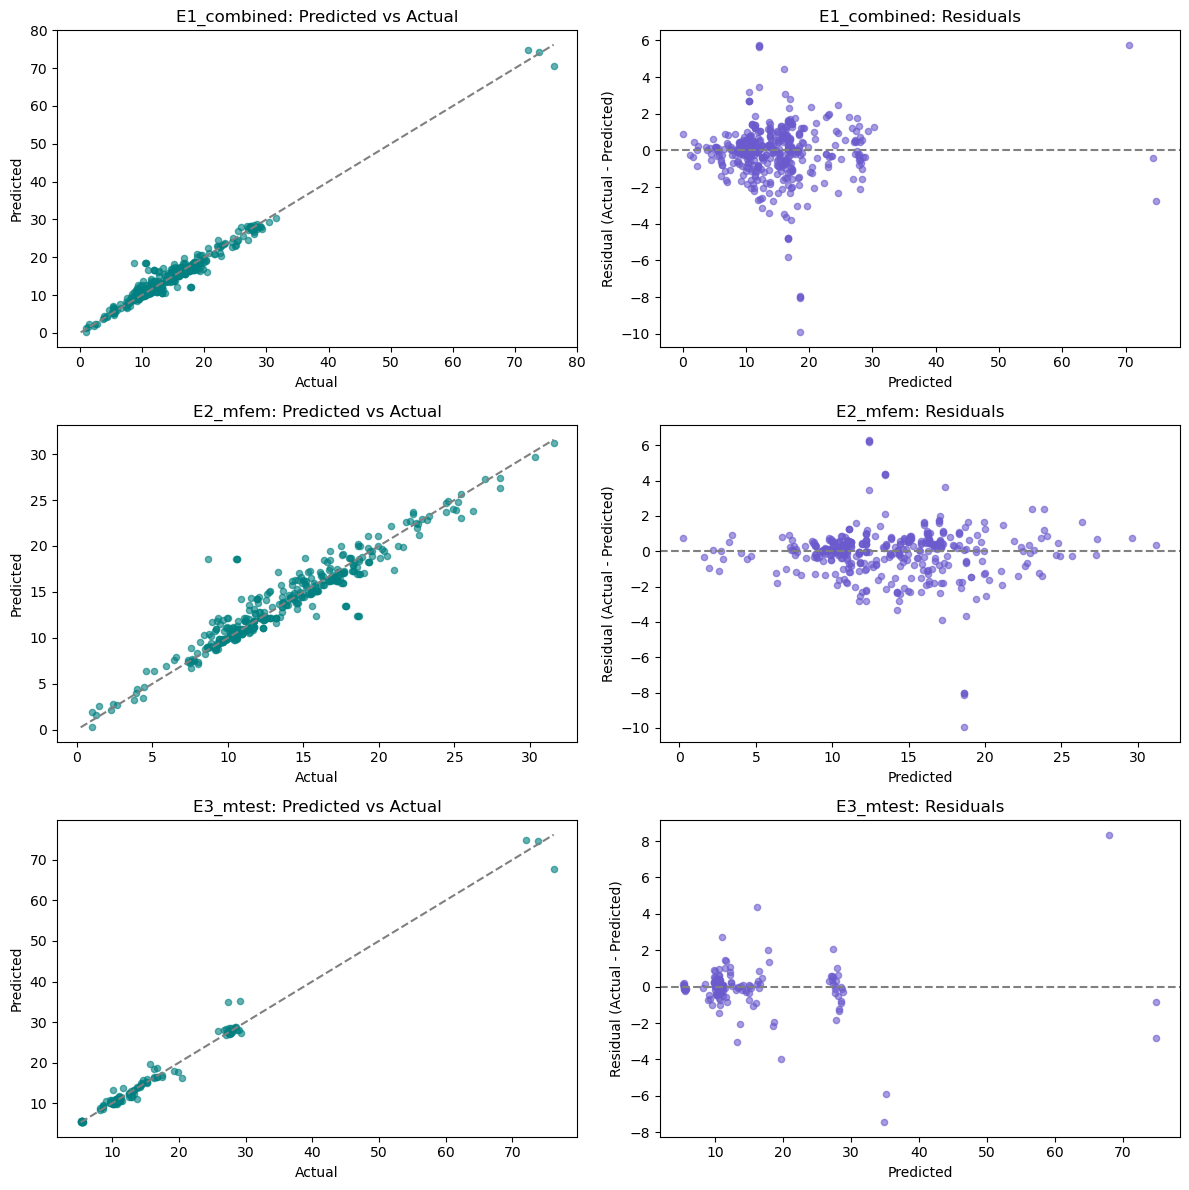

/var/folders/2r/65b3v1496498f35zwrwmt7900000gn/T/ipykernel_24038/2421016311.py:217: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=cats, showfliers=False)
/var/folders/2r/65b3v1496498f35zwrwmt7900000gn/T/ipykernel_24038/2421016311.py:217: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=cats, showfliers=False)
/var/folders/2r/65b3v1496498f35zwrwmt7900000gn/T/ipykernel_24038/2421016311.py:217: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=cats, showfliers=False)


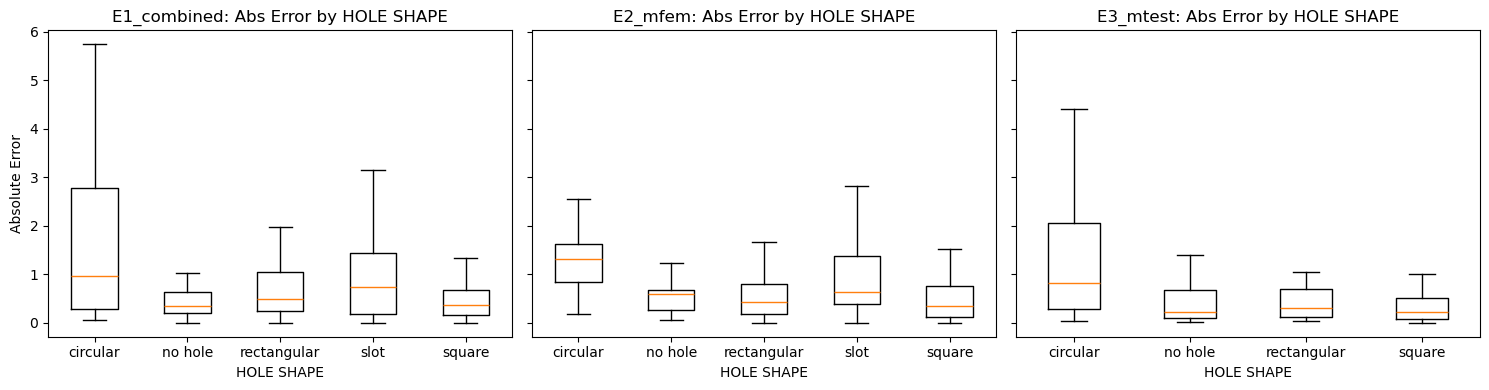

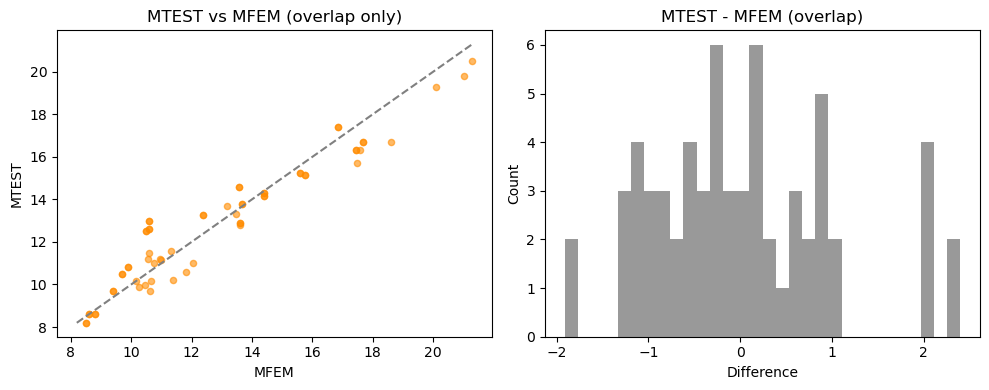

In [15]:
# Checkpoint 9: Post-model EDA (leakage-safe, out-of-fold predictions).
# - Build OOF predictions for best tuned model per experiment (E1/E2/E3).
# - Plot predicted vs actual and residuals.
# - Plot absolute error by HOLE SHAPE.
# - MFEM–MTEST overlap analysis (scatter + difference histogram).

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

if "df_clean" not in globals():
    raise NameError("df_clean not found. Run prior checkpoints first.")

def norm_col(name):
    return "".join(ch for ch in str(name).lower() if ch.isalnum())

def find_col(df, key):
    return next((c for c in df.columns if key in c.lower()), None)

def normalize_shape(s):
    s = s.astype(str).str.strip().str.lower()
    s = s.replace({
        "nan": pd.NA,
        "none": "no hole",
        "nohole": "no hole",
        "no holes": "no hole",
        "solid": "no hole",
    })
    shape_map = {
        "c": "circular", "circle": "circular", "circular": "circular",
        "r": "rectangular", "rect": "rectangular", "rectangle": "rectangular", "rectangular": "rectangular",
        "s": "square", "sq": "square", "square": "square",
        "slot": "slot", "slotted": "slot", "elongated": "slot",
    }
    return s.replace(shape_map)

# Use tuned results if available; fallback to baseline
results_cv = globals().get("results_df_tuned", None)
if results_cv is None:
    results_cv = globals().get("results_store", {}).get("tuned_cv", None)
if results_cv is None:
    results_cv = globals().get("results_df", None)
if results_cv is None:
    results_cv = globals().get("results_store", {}).get("baseline_cv", None)
if results_cv is None:
    raise NameError("No CV results found. Run Checkpoint 7/8 first.")

df_work = df_clean.copy()

mtest_col = find_col(df_work, "mtest")
mfem_col = find_col(df_work, "mfem")
hole_shape_col = find_col(df_work, "hole shape")
if mtest_col is None or mfem_col is None or hole_shape_col is None:
    raise ValueError("Missing MTEST/MFEM/HOLE SHAPE columns. Check column names.")

df_work[mtest_col] = pd.to_numeric(df_work[mtest_col], errors="coerce")
df_work[mfem_col] = pd.to_numeric(df_work[mfem_col], errors="coerce")

# Name-based drop list (robust to column shifts)
drop_keys = {
    "slno", "journaltitle", "specimen", "shapecode",
    "boundarycondition", "loadingcondition",
    "failuremode", "aisi", "eurocode3", "asnzs",
    "q",
}
drop_cols = [c for c in df_work.columns if norm_col(c) in drop_keys]

exclude = set(drop_cols + [mtest_col, mfem_col, "y", "y_combined", "geometry_signature"])
feature_cols = [c for c in df_work.columns if c not in exclude]

# Split numeric vs categorical and drop constant/all-missing columns
cat_cols = [c for c in feature_cols if df_work[c].dtype == object]
num_cols = [c for c in feature_cols if c not in cat_cols]

num_cols = [c for c in num_cols if df_work[c].dropna().nunique() > 1]
cat_cols = [c for c in cat_cols if df_work[c].dropna().nunique() > 1]
feature_cols = num_cols + cat_cols

print(f"Feature columns used for post-model EDA: {len(feature_cols)} (num={len(num_cols)}, cat={len(cat_cols)})")

# Preprocessor
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe),
])

transformers = [("num", numeric_transformer, num_cols)]
if cat_cols:
    transformers.append(("cat", categorical_transformer, cat_cols))
preprocessor = ColumnTransformer(transformers)

# Geometry signature (for grouping)
sig_df = df_work[feature_cols].copy()
for c in sig_df.columns:
    if pd.api.types.is_numeric_dtype(sig_df[c]):
        sig_df[c] = sig_df[c].fillna(-999999)
    else:
        sig_df[c] = sig_df[c].fillna("MISSING").astype(str)

df_work["geometry_signature"] = pd.util.hash_pandas_object(sig_df, index=False).astype("int64")

# Experiments
exp_dfs = {
    "E1_combined": df_work[df_work[mtest_col].notna() | df_work[mfem_col].notna()].copy(),
    "E2_mfem": df_work[df_work[mfem_col].notna()].copy(),
    "E3_mtest": df_work[df_work[mtest_col].notna()].copy(),
}
exp_dfs["E1_combined"]["y"] = exp_dfs["E1_combined"][mtest_col].where(
    exp_dfs["E1_combined"][mtest_col].notna(), exp_dfs["E1_combined"][mfem_col]
)
exp_dfs["E2_mfem"]["y"] = exp_dfs["E2_mfem"][mfem_col]
exp_dfs["E3_mtest"]["y"] = exp_dfs["E3_mtest"][mtest_col]

# Best model per experiment (by MAE)
best_rows = (
    results_cv.sort_values(["experiment", "mae_mean"])
    .groupby("experiment", as_index=False)
    .head(1)
    .set_index("experiment")
)

model_map = {
    "Ridge": Ridge(),
    "Lasso": Lasso(max_iter=20000, random_state=0),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=0),
    "GradientBoosting": GradientBoostingRegressor(random_state=0),
}

preds = {}
residuals = {}

for exp_name, d in exp_dfs.items():
    if exp_name not in best_rows.index:
        raise ValueError(f"Missing best model info for {exp_name}")

    model_name = best_rows.loc[exp_name, "model"]
    best_params = best_rows.loc[exp_name, "best_params"]

    base_model = model_map.get(model_name)
    if base_model is None:
        raise ValueError(f"Unknown model name: {model_name}")

    pipe = Pipeline([("preprocess", preprocessor), ("model", base_model)])

    # best_params might be stored as dict or string
    if isinstance(best_params, str) and best_params.startswith("{"):
        best_params = ast.literal_eval(best_params)
    if isinstance(best_params, dict):
        pipe.set_params(**best_params)

    X = d[feature_cols]
    y = d["y"]
    groups = d["geometry_signature"]

    gkf = GroupKFold(n_splits=5)
    y_pred = cross_val_predict(pipe, X, y, groups=groups, cv=gkf, n_jobs=-1)
    preds[exp_name] = pd.Series(y_pred, index=d.index)
    residuals[exp_name] = y - y_pred

# Predicted vs Actual + Residuals
exp_order = ["E1_combined", "E2_mfem", "E3_mtest"]
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
for i, exp_name in enumerate(exp_order):
    d = exp_dfs[exp_name]
    y = d["y"]
    y_pred = preds[exp_name]
    resid = residuals[exp_name]

    ax1 = axes[i, 0]
    ax1.scatter(y, y_pred, alpha=0.6, s=20, color="teal")
    min_v = min(y.min(), y_pred.min())
    max_v = max(y.max(), y_pred.max())
    ax1.plot([min_v, max_v], [min_v, max_v], "--", color="gray")
    ax1.set_title(f"{exp_name}: Predicted vs Actual")
    ax1.set_xlabel("Actual")
    ax1.set_ylabel("Predicted")

    ax2 = axes[i, 1]
    ax2.scatter(y_pred, resid, alpha=0.6, s=20, color="slateblue")
    ax2.axhline(0, color="gray", linestyle="--")
    ax2.set_title(f"{exp_name}: Residuals")
    ax2.set_xlabel("Predicted")
    ax2.set_ylabel("Residual (Actual - Predicted)")

plt.tight_layout()
plt.show()

# Error by HOLE SHAPE (absolute error)
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
for i, exp_name in enumerate(exp_order):
    d = exp_dfs[exp_name]
    shapes = normalize_shape(d[hole_shape_col])
    abs_err = np.abs(residuals[exp_name])

    cats = sorted([c for c in shapes.dropna().unique().tolist()])
    data = [abs_err[shapes == c].values for c in cats]

    axes[i].boxplot(data, labels=cats, showfliers=False)
    axes[i].set_title(f"{exp_name}: Abs Error by HOLE SHAPE")
    axes[i].set_xlabel("HOLE SHAPE")
    if i == 0:
        axes[i].set_ylabel("Absolute Error")

plt.tight_layout()
plt.show()

# MFEM–MTEST overlap analysis
overlap = df_work[df_work[mtest_col].notna() & df_work[mfem_col].notna()].copy()
diff = overlap[mtest_col] - overlap[mfem_col]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(overlap[mfem_col], overlap[mtest_col], alpha=0.6, s=20, color="darkorange")
min_v = min(overlap[mfem_col].min(), overlap[mtest_col].min())
max_v = max(overlap[mfem_col].max(), overlap[mtest_col].max())
axes[0].plot([min_v, max_v], [min_v, max_v], "--", color="gray")
axes[0].set_title("MTEST vs MFEM (overlap only)")
axes[0].set_xlabel("MFEM")
axes[0].set_ylabel("MTEST")

axes[1].hist(diff.dropna(), bins=30, color="gray", alpha=0.8)
axes[1].set_title("MTEST - MFEM (overlap)")
axes[1].set_xlabel("Difference")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

# Store predictions/residuals for later reporting
results_store = globals().get("results_store", {})
results_store["post_model_preds"] = {k: preds[k] for k in exp_order}
results_store["post_model_residuals"] = {k: residuals[k] for k in exp_order}
globals()["results_store"] = results_store


### Scatter plots with correlation
Add Pearson r to predicted vs actual plots.


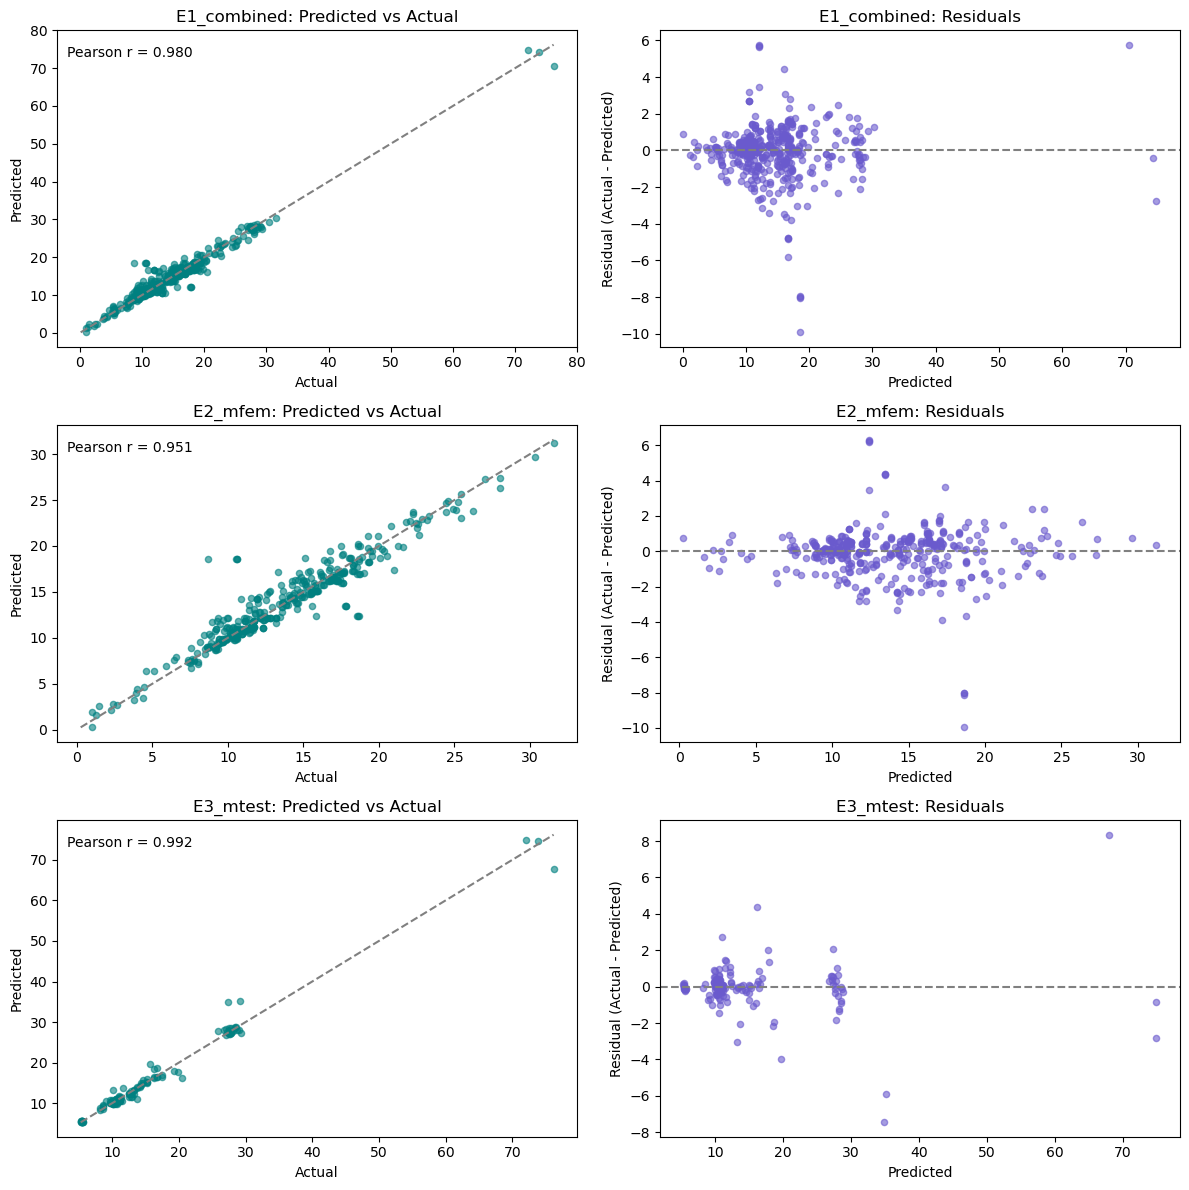

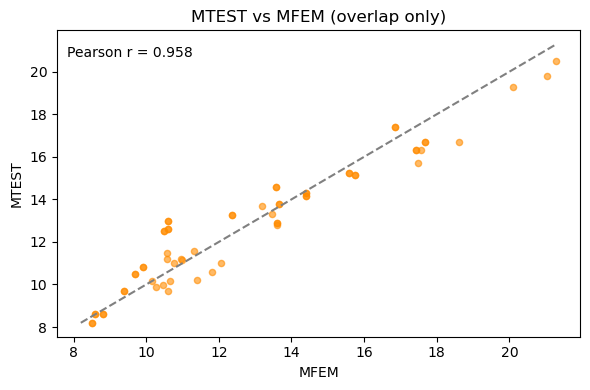

In [16]:
# Re-plot scatter panels with Pearson correlation annotations (no new model fitting).
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if "df_clean" not in globals():
    raise NameError("df_clean not found. Run prior checkpoints first.")
if "results_store" not in globals() or "post_model_preds" not in results_store:
    raise NameError("OOF predictions not found. Run Checkpoint 9 first.")

def find_col(df, key):
    return next((c for c in df.columns if key in c.lower()), None)

def safe_corr(a, b):
    a = pd.Series(a).astype(float)
    b = pd.Series(b).astype(float)
    m = a.notna() & b.notna()
    if m.sum() < 2:
        return np.nan
    return float(np.corrcoef(a[m], b[m])[0, 1])

df_base = df_clean.copy()
mtest_col = find_col(df_base, "mtest")
mfem_col = find_col(df_base, "mfem")
if mtest_col is None or mfem_col is None:
    raise ValueError("MTEST/MFEM columns not found.")

df_base[mtest_col] = pd.to_numeric(df_base[mtest_col], errors="coerce")
df_base[mfem_col] = pd.to_numeric(df_base[mfem_col], errors="coerce")

exp_dfs = {
    "E1_combined": df_base[df_base[mtest_col].notna() | df_base[mfem_col].notna()].copy(),
    "E2_mfem": df_base[df_base[mfem_col].notna()].copy(),
    "E3_mtest": df_base[df_base[mtest_col].notna()].copy(),
}
exp_dfs["E1_combined"]["y"] = exp_dfs["E1_combined"][mtest_col].where(
    exp_dfs["E1_combined"][mtest_col].notna(), exp_dfs["E1_combined"][mfem_col]
)
exp_dfs["E2_mfem"]["y"] = exp_dfs["E2_mfem"][mfem_col]
exp_dfs["E3_mtest"]["y"] = exp_dfs["E3_mtest"][mtest_col]

preds = results_store["post_model_preds"]

# Predicted vs Actual + Residuals with r annotation on scatter only
exp_order = ["E1_combined", "E2_mfem", "E3_mtest"]
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
for i, exp_name in enumerate(exp_order):
    d = exp_dfs[exp_name]
    y = d["y"]
    y_pred = preds[exp_name].reindex(d.index)
    resid = y - y_pred

    r = safe_corr(y, y_pred)

    ax1 = axes[i, 0]
    ax1.scatter(y, y_pred, alpha=0.6, s=20, color="teal")
    min_v = min(y.min(), y_pred.min())
    max_v = max(y.max(), y_pred.max())
    ax1.plot([min_v, max_v], [min_v, max_v], "--", color="gray")
    ax1.set_title(f"{exp_name}: Predicted vs Actual")
    ax1.set_xlabel("Actual")
    ax1.set_ylabel("Predicted")
    ax1.text(0.02, 0.95, f"Pearson r = {r:.3f}", transform=ax1.transAxes, va="top")

    ax2 = axes[i, 1]
    ax2.scatter(y_pred, resid, alpha=0.6, s=20, color="slateblue")
    ax2.axhline(0, color="gray", linestyle="--")
    ax2.set_title(f"{exp_name}: Residuals")
    ax2.set_xlabel("Predicted")
    ax2.set_ylabel("Residual (Actual - Predicted)")

plt.tight_layout()
plt.show()

# MFEM–MTEST overlap scatter with correlation annotation
overlap = df_base[df_base[mtest_col].notna() & df_base[mfem_col].notna()].copy()
r_overlap = safe_corr(overlap[mfem_col], overlap[mtest_col])

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.scatter(overlap[mfem_col], overlap[mtest_col], alpha=0.6, s=20, color="darkorange")
min_v = min(overlap[mfem_col].min(), overlap[mtest_col].min())
max_v = max(overlap[mfem_col].max(), overlap[mtest_col].max())
ax.plot([min_v, max_v], [min_v, max_v], "--", color="gray")
ax.set_title("MTEST vs MFEM (overlap only)")
ax.set_xlabel("MFEM")
ax.set_ylabel("MTEST")
ax.text(0.02, 0.95, f"Pearson r = {r_overlap:.3f}", transform=ax.transAxes, va="top")

plt.tight_layout()
plt.show()


## 14) Feature importance
Linear standardized coefficients and tree permutation importance.


In [17]:
# Checkpoint 10: Feature importance (linear coeffs + tree permutation) + top-k overlaps.
# - Uses best tuned model per family (linear/tree) from results_df_tuned (or baseline fallback).
# - Fits each best model on its experiment data.
# - Linear: standardized coefficients (from pipeline with StandardScaler).
# - Tree: permutation importance (MAE-based).
# - Compares top-k overlaps across experiments and stores outputs.

import numpy as np
import pandas as pd
import ast

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

if "df_clean" not in globals():
    raise NameError("df_clean not found. Run prior checkpoints first.")

def norm_col(name):
    return "".join(ch for ch in str(name).lower() if ch.isalnum())

def find_col(df, key):
    return next((c for c in df.columns if key in c.lower()), None)

# Choose tuned CV results if available, else baseline
results_cv = globals().get("results_df_tuned", None)
if results_cv is None:
    results_cv = globals().get("results_store", {}).get("tuned_cv", None)
if results_cv is None:
    results_cv = globals().get("results_df", None)
if results_cv is None:
    results_cv = globals().get("results_store", {}).get("baseline_cv", None)
if results_cv is None:
    raise NameError("No CV results found. Run Checkpoint 7/8 first.")

df_work = df_clean.copy()
mtest_col = find_col(df_work, "mtest")
mfem_col = find_col(df_work, "mfem")
if mtest_col is None or mfem_col is None:
    raise ValueError("MTEST/MFEM columns not found.")

df_work[mtest_col] = pd.to_numeric(df_work[mtest_col], errors="coerce")
df_work[mfem_col] = pd.to_numeric(df_work[mfem_col], errors="coerce")

# Build experiment datasets
exp_dfs = {
    "E1_combined": df_work[df_work[mtest_col].notna() | df_work[mfem_col].notna()].copy(),
    "E2_mfem": df_work[df_work[mfem_col].notna()].copy(),
    "E3_mtest": df_work[df_work[mtest_col].notna()].copy(),
}
exp_dfs["E1_combined"]["y"] = exp_dfs["E1_combined"][mtest_col].where(
    exp_dfs["E1_combined"][mtest_col].notna(), exp_dfs["E1_combined"][mfem_col]
)
exp_dfs["E2_mfem"]["y"] = exp_dfs["E2_mfem"][mfem_col]
exp_dfs["E3_mtest"]["y"] = exp_dfs["E3_mtest"][mtest_col]

# Name-based drops (robust to column shifts)
drop_keys = {
    "slno", "journaltitle", "specimen", "shapecode",
    "boundarycondition", "loadingcondition",
    "failuremode", "aisi", "eurocode3", "asnzs",
    "q",
}
drop_cols = [c for c in df_work.columns if norm_col(c) in drop_keys]

exclude = set(drop_cols + [mtest_col, mfem_col, "y", "y_combined", "geometry_signature"])
feature_cols = [c for c in df_work.columns if c not in exclude]

# Split numeric vs categorical and drop constant/all-missing
cat_cols = [c for c in feature_cols if df_work[c].dtype == object]
num_cols = [c for c in feature_cols if c not in cat_cols]
num_cols = [c for c in num_cols if df_work[c].dropna().nunique() > 1]
cat_cols = [c for c in cat_cols if df_work[c].dropna().nunique() > 1]
feature_cols = num_cols + cat_cols

print(f"Feature columns used: {len(feature_cols)} (num={len(num_cols)}, cat={len(cat_cols)})")

# Preprocessor
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler()),
])
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", ohe),
])

transformers = [("num", numeric_transformer, num_cols)]
if cat_cols:
    transformers.append(("cat", categorical_transformer, cat_cols))

preprocessor = ColumnTransformer(transformers)

# Best models per family (linear/tree) per experiment
best_family = (
    results_cv.sort_values(["experiment", "model_family", "mae_mean"])
    .groupby(["experiment", "model_family"], as_index=False)
    .head(1)
)

best_lookup = {
    (row["experiment"], row["model_family"]): row
    for _, row in best_family.iterrows()
}

# Model builders
model_builders = {
    "Ridge": lambda: Ridge(),
    "Lasso": lambda: Lasso(max_iter=50000, random_state=0),
    "RandomForest": lambda: RandomForestRegressor(n_estimators=200, random_state=0),
    "GradientBoosting": lambda: GradientBoostingRegressor(random_state=0),
}

def parse_params(p):
    if isinstance(p, dict):
        return p
    if isinstance(p, str) and p.startswith("{"):
        return ast.literal_eval(p)
    return {}

def get_feature_names(preproc):
    try:
        return list(preproc.get_feature_names_out())
    except Exception:
        names = [f"num__{c}" for c in num_cols]
        if cat_cols:
            ohe_ = preproc.named_transformers_["cat"].named_steps["onehot"]
            cat_names = list(ohe_.get_feature_names_out(cat_cols))
            names += [f"cat__{n}" for n in cat_names]
        return names

def base_name(fname):
    if fname.startswith("num__"):
        return fname[len("num__"):]
    if fname.startswith("cat__"):
        name = fname[len("cat__"):]
        parts = name.split("_", 1)
        return parts[0]
    return fname

linear_importances = {}
linear_importances_agg = {}
tree_importances = {}

topk = 10
exp_order = ["E1_combined", "E2_mfem", "E3_mtest"]

for exp in exp_order:
    d = exp_dfs[exp]
    X = d[feature_cols]
    y = d["y"]

    # Linear importance (standardized coefficients)
    lin_row = best_lookup[(exp, "linear")]
    lin_model_name = lin_row["model"]
    lin_params = parse_params(lin_row.get("best_params", {}))

    lin_pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model_builders[lin_model_name]()),
    ])
    if lin_params:
        lin_pipe.set_params(**lin_params)
    lin_pipe.fit(X, y)

    feat_names = get_feature_names(lin_pipe.named_steps["preprocess"])
    coef = lin_pipe.named_steps["model"].coef_
    coef = np.array(coef).ravel()

    coef_df = pd.DataFrame({
        "feature": feat_names,
        "coef": coef,
        "abs_coef": np.abs(coef),
    }).sort_values("abs_coef", ascending=False)

    coef_df["base_feature"] = coef_df["feature"].apply(base_name)
    coef_agg = coef_df.groupby("base_feature", as_index=False)["abs_coef"].sum()
    coef_agg = coef_agg.sort_values("abs_coef", ascending=False)

    linear_importances[exp] = coef_df
    linear_importances_agg[exp] = coef_agg

    # Tree importance (permutation on original feature columns)
    tree_row = best_lookup[(exp, "tree")]
    tree_model_name = tree_row["model"]
    tree_params = parse_params(tree_row.get("best_params", {}))

    tree_pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model_builders[tree_model_name]()),
    ])
    if tree_params:
        tree_pipe.set_params(**tree_params)
    tree_pipe.fit(X, y)

    perm = permutation_importance(
        tree_pipe, X, y,
        n_repeats=10,
        random_state=0,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    )
    perm_df = pd.DataFrame({
        "feature": feature_cols,
        "importance_mean": perm.importances_mean,
        "importance_std": perm.importances_std,
    }).sort_values("importance_mean", ascending=False)

    tree_importances[exp] = perm_df

# Display top-k tables
for exp in exp_order:
    print(f"\n{exp} - Linear (standardized coeffs, aggregated by base feature) Top {topk}")
    display(linear_importances_agg[exp].head(topk))

    print(f"{exp} - Tree (permutation importance) Top {topk}")
    display(tree_importances[exp].head(topk))

# Overlap analysis (top-k)
def topk_list(d, k):
    return d.head(k)["feature"].tolist()

def topk_list_agg(d, k):
    return d.head(k)["base_feature"].tolist()

topk_linear = {exp: topk_list_agg(linear_importances_agg[exp], topk) for exp in exp_order}
topk_tree = {exp: topk_list(tree_importances[exp], topk) for exp in exp_order}

def overlap_table(topk_dict, label):
    sets = {k: set(v) for k, v in topk_dict.items()}
    all_intersection = set.intersection(*sets.values())
    rows = [
        {"pair": "E1 vs E2", "overlap": len(sets["E1_combined"] & sets["E2_mfem"]), "features": sorted(list(sets["E1_combined"] & sets["E2_mfem"]))},
        {"pair": "E1 vs E3", "overlap": len(sets["E1_combined"] & sets["E3_mtest"]), "features": sorted(list(sets["E1_combined"] & sets["E3_mtest"]))},
        {"pair": "E2 vs E3", "overlap": len(sets["E2_mfem"] & sets["E3_mtest"]), "features": sorted(list(sets["E2_mfem"] & sets["E3_mtest"]))},
        {"pair": "All three", "overlap": len(all_intersection), "features": sorted(list(all_intersection))},
    ]
    print(f"\nTop-{topk} overlap for {label}:")
    display(pd.DataFrame(rows))

overlap_table(topk_linear, "linear (aggregated)")
overlap_table(topk_tree, "tree (permutation)")

# Store in results_store
results_store = globals().get("results_store", {})
results_store["linear_importances_full"] = linear_importances
results_store["linear_importances_agg"] = linear_importances_agg
results_store["tree_perm_importances"] = tree_importances
results_store["topk_overlap"] = {"linear": topk_linear, "tree": topk_tree}
globals()["results_store"] = results_store


Feature columns used: 17 (num=16, cat=1)

E1_combined - Linear (standardized coeffs, aggregated by base feature) Top 10


,base_feature,abs_coef
23,t,6.328342
4,E,3.713387
7,HOLE SHAPE,2.894825
20,missingindicator_r hole,2.409910
10,bf_avg,2.140776
3,Distance from top to centre of first hole Y,2.044385
21,r,2.030713
0,bw,1.526479
11,bl_avg,1.233463
8,L,0.973899


E1_combined - Tree (permutation importance) Top 10


,feature,importance_mean,importance_std
3,t,3.478531,0.158755
6,r,1.406197,0.036893
11,Distance from top to centre of first hole Y,0.796484,0.031495
8,h hole,0.664469,0.034005
15,bl_avg,0.431639,0.021118
7,l hole,0.426282,0.019771
5,bw,0.421970,0.024479
1,Fu,0.316902,0.019374
12,Distance from left to centre of first hole X,0.211475,0.013239
4,L,0.192362,0.012068



E2_mfem - Linear (standardized coeffs, aggregated by base feature) Top 10


,base_feature,abs_coef
0,bw,3.663623
23,t,3.013164
11,bl_avg,1.274569
12,h hole,1.146749
6,Fy,0.732291
13,l hole,0.725707
8,L,0.675949
2,Distance from left to centre of first hole X,0.477211
7,HOLE SHAPE,0.440111
20,missingindicator_r hole,0.418498


E2_mfem - Tree (permutation importance) Top 10


,feature,importance_mean,importance_std
3,t,1.760224,0.044630
6,r,1.348718,0.034273
8,h hole,0.887624,0.060171
4,L,0.527470,0.024002
15,bl_avg,0.430348,0.037177
11,Distance from top to centre of first hole Y,0.384348,0.028226
7,l hole,0.379439,0.027920
5,bw,0.260869,0.020029
12,Distance from left to centre of first hole X,0.129629,0.017848
1,Fu,0.066361,0.008624



E3_mtest - Linear (standardized coeffs, aggregated by base feature) Top 10


,base_feature,abs_coef
23,t,9.325821
4,E,4.295299
10,bf_avg,1.924089
3,Distance from top to centre of first hole Y,1.530722
5,Fu,1.372502
21,r,1.016064
20,missingindicator_r hole,0.928994
6,Fy,0.780141
7,HOLE SHAPE,0.677235
11,bl_avg,0.578919


E3_mtest - Tree (permutation importance) Top 10


,feature,importance_mean,importance_std
11,Distance from top to centre of first hole Y,2.802672,0.227088
3,t,2.209902,0.111278
5,bw,1.498043,0.142139
14,bf_avg,1.187074,0.016787
1,Fu,0.585470,0.036378
6,r,0.504759,0.021972
15,bl_avg,0.420175,0.027354
0,Fy,0.313992,0.008612
10,Number Of Holes in Channel,0.306691,0.005865
8,h hole,0.210003,0.017201



Top-10 overlap for linear (aggregated):


,pair,overlap,features
0,E1 vs E2,6,"[ bw, HOLE SHAPE, L, bl_avg, missingindicator_..."
1,E1 vs E3,8,[Distance from top to centre of first hole Y ...
2,E2 vs E3,5,"[Fy, HOLE SHAPE, bl_avg, missingindicator_r ho..."
3,All three,4,"[HOLE SHAPE, bl_avg, missingindicator_r hole, t]"



Top-10 overlap for tree (permutation):


,pair,overlap,features
0,E1 vs E2,10,"[ bw, Distance from left to centre of first h..."
1,E1 vs E3,7,"[ bw, Distance from top to centre of first hol..."
2,E2 vs E3,7,"[ bw, Distance from top to centre of first hol..."
3,All three,7,"[ bw, Distance from top to centre of first hol..."


## 15) Diagnostics: domain alignment, error by shape/journal, ratios
Quantify alignment with domain expectations and check error patterns.


Top-k domain alignment (count and share):


,experiment,family,in_domain,k,share
0,E1_combined,linear,10,10,1.0
1,E1_combined,tree,10,10,1.0
2,E2_mfem,linear,10,10,1.0
3,E2_mfem,tree,10,10,1.0
4,E3_mtest,linear,10,10,1.0
5,E3_mtest,tree,10,10,1.0


Top-k overlap across all experiments (and domain alignment):


,family,overlap_count,in_domain,features
0,linear,4,4,"[HOLE SHAPE, bl_avg, missingindicator_r hole, t]"
1,tree,7,7,"[ bw, Distance from top to centre of first hol..."


E1 combined: Absolute error by HOLE SHAPE


,count,mean,median,p90
hole_shape_norm,,,,
circular,28,1.520783,0.966284,3.265368
slot,204,1.174380,0.729423,2.669589
rectangular,118,0.721287,0.499311,1.526075
no hole,34,0.516942,0.349412,1.017318
square,108,0.480532,0.358175,1.086943


E1 combined: Absolute error by JOURNAL TITLE (top 10 by count, count>=5)


,count,mean,median
JOURNAL TITLE,,,
"Chandramohan et al., 2025",204,1.174380,0.729423
"Zhao et al., 2019",88,0.804702,0.574382
Oruç 1 2025,84,0.465132,0.346396
Soroori Rad 2011,63,0.540198,0.386728
Moen et al. 2013,18,0.494422,0.496731
"Chen et al.,2020",14,2.190948,1.954915
"Sivakumaran et al., 2006",9,0.183815,0.155557
"Tohamy et al., 2021",8,0.287852,0.114284


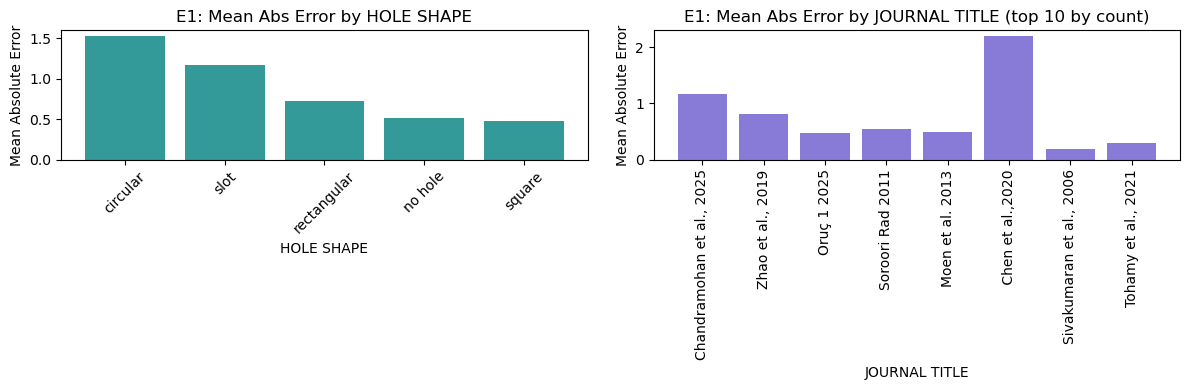

Ratio-feature correlations with targets:


target,COMBINED,MFEM,MTEST
ratio,,,
bf_avg_t,-0.474810,-0.500604,-0.510505
bl_avg_t,-0.333378,-0.320407,-0.450094
bw_t,-0.422229,-0.432588,-0.466178
h_hole_bw,-0.347183,-0.374145,-0.322663


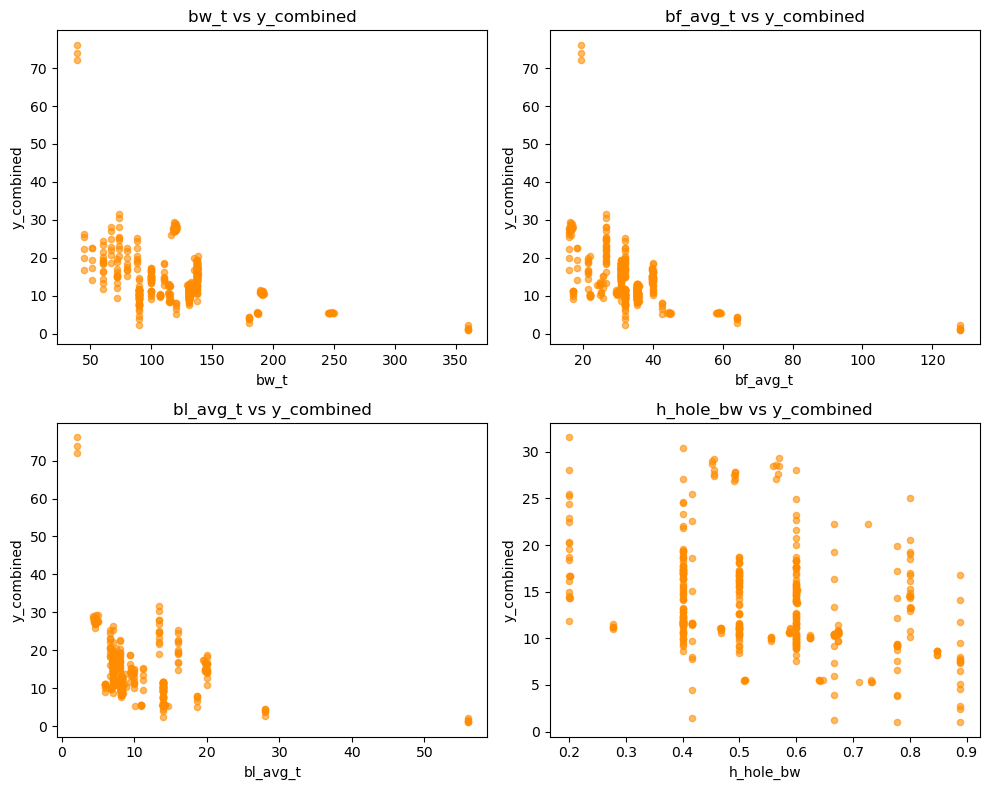

In [18]:
# This cell:
# 1) Quantifies how top-k important features align with domain expectations (linear + tree).
# 2) Summarizes absolute error by HOLE SHAPE and by JOURNAL TITLE (E1 combined, OOF preds).
# 3) Computes ratio features (bw/t, bf_avg/t, bl_avg/t, h_hole/bw) and shows correlations + scatter vs targets.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if "df_clean" not in globals():
    raise NameError("df_clean not found. Run prior checkpoints first.")
if "results_store" not in globals():
    raise NameError("results_store not found. Run Checkpoint 10 first.")

# ---------- Helpers ----------
def norm_key(s):
    return "".join(ch for ch in str(s).lower() if ch.isalnum())

def find_col(df, key):
    return next((c for c in df.columns if key in c.lower()), None)

def normalize_shape(s):
    s = s.astype(str).str.strip().str.lower()
    s = s.replace({
        "nan": pd.NA,
        "none": "no hole",
        "nohole": "no hole",
        "no holes": "no hole",
        "solid": "no hole",
    })
    shape_map = {
        "c": "circular", "circle": "circular", "circular": "circular",
        "r": "rectangular", "rect": "rectangular", "rectangle": "rectangular", "rectangular": "rectangular",
        "s": "square", "sq": "square", "square": "square",
        "slot": "slot", "slotted": "slot", "elongated": "slot",
    }
    return s.replace(shape_map)

def safe_div(a, b):
    a = pd.to_numeric(a, errors="coerce")
    b = pd.to_numeric(b, errors="coerce")
    out = a / b
    out[(b == 0) | b.isna()] = np.nan
    return out

# ---------- 1) Domain alignment of top-k importances ----------
linear_agg = results_store.get("linear_importances_agg", None)
tree_perm = results_store.get("tree_perm_importances", None)
if linear_agg is None or tree_perm is None:
    raise NameError("Missing importance outputs. Run Checkpoint 10 first.")

domain_features = [
    "t", "bw", "bf_avg", "bl_avg", "r", "r hole", "h hole", "l hole",
    "Number Of Holes in Channel",
    "Distance from top to centre of first hole Y",
    "Distance from left to centre of first hole X",
    "Centre to centre distance between adjesent holes in X direction Sx",
    "HOLE SHAPE", "Fy", "Fu", "E", "L",
    "missingindicator_r_hole"
]
domain_set = {norm_key(x) for x in domain_features}

def in_domain(name):
    return norm_key(name) in domain_set

topk = 10
exp_order = ["E1_combined", "E2_mfem", "E3_mtest"]

rows = []
lin_topk_sets = {}
tree_topk_sets = {}
for exp in exp_order:
    lin_topk = linear_agg[exp].head(topk)["base_feature"].tolist()
    tree_topk = tree_perm[exp].head(topk)["feature"].tolist()
    lin_topk_sets[exp] = set(lin_topk)
    tree_topk_sets[exp] = set(tree_topk)

    rows.append({
        "experiment": exp,
        "family": "linear",
        "in_domain": sum(in_domain(f) for f in lin_topk),
        "k": topk,
        "share": round(sum(in_domain(f) for f in lin_topk) / topk, 2),
    })
    rows.append({
        "experiment": exp,
        "family": "tree",
        "in_domain": sum(in_domain(f) for f in tree_topk),
        "k": topk,
        "share": round(sum(in_domain(f) for f in tree_topk) / topk, 2),
    })

domain_align_df = pd.DataFrame(rows)
print("Top-k domain alignment (count and share):")
display(domain_align_df)

# Overlap across experiments
lin_overlap = set.intersection(*lin_topk_sets.values())
tree_overlap = set.intersection(*tree_topk_sets.values())

overlap_df = pd.DataFrame([
    {"family": "linear", "overlap_count": len(lin_overlap), "in_domain": sum(in_domain(f) for f in lin_overlap), "features": sorted(lin_overlap)},
    {"family": "tree", "overlap_count": len(tree_overlap), "in_domain": sum(in_domain(f) for f in tree_overlap), "features": sorted(tree_overlap)},
])
print("Top-k overlap across all experiments (and domain alignment):")
display(overlap_df)

# ---------- 2) Error analysis by HOLE SHAPE and JOURNAL TITLE (E1 combined) ----------
post_resid = results_store.get("post_model_residuals", None)
if post_resid is None or "E1_combined" not in post_resid:
    raise NameError("Missing OOF residuals. Run Checkpoint 9 first.")

df_base = df_clean.copy()
mtest_col = find_col(df_base, "mtest")
mfem_col = find_col(df_base, "mfem")
hole_shape_col = find_col(df_base, "hole shape")
journal_col = find_col(df_base, "journal title")

df_base[mtest_col] = pd.to_numeric(df_base[mtest_col], errors="coerce")
df_base[mfem_col] = pd.to_numeric(df_base[mfem_col], errors="coerce")

df_e1 = df_base[df_base[mtest_col].notna() | df_base[mfem_col].notna()].copy()
df_e1["y"] = df_e1[mtest_col].where(df_e1[mtest_col].notna(), df_e1[mfem_col])

abs_err = post_resid["E1_combined"].abs().reindex(df_e1.index)

df_e1["hole_shape_norm"] = normalize_shape(df_e1[hole_shape_col])
df_e1["abs_err"] = abs_err

# Hole shape summary
hole_err = df_e1.groupby("hole_shape_norm")["abs_err"].agg(
    count="count", mean="mean", median="median", p90=lambda s: s.quantile(0.9)
).sort_values("mean", ascending=False)

print("E1 combined: Absolute error by HOLE SHAPE")
display(hole_err)

# Journal summary (only if column exists)
if journal_col:
    journal_err = df_e1.groupby(journal_col)["abs_err"].agg(
        count="count", mean="mean", median="median"
    )
    # Keep reasonably sized groups and show top 10 by count
    journal_err = journal_err[journal_err["count"] >= 5].sort_values("count", ascending=False).head(10)
    print("E1 combined: Absolute error by JOURNAL TITLE (top 10 by count, count>=5)")
    display(journal_err)

# Simple plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar: mean abs error by hole shape
axes[0].bar(hole_err.index.astype(str), hole_err["mean"], color="teal", alpha=0.8)
axes[0].set_title("E1: Mean Abs Error by HOLE SHAPE")
axes[0].set_xlabel("HOLE SHAPE")
axes[0].set_ylabel("Mean Absolute Error")
axes[0].tick_params(axis="x", rotation=45)

# Bar: mean abs error by journal (top 10 by count)
if journal_col and not journal_err.empty:
    axes[1].bar(journal_err.index.astype(str), journal_err["mean"], color="slateblue", alpha=0.8)
    axes[1].set_title("E1: Mean Abs Error by JOURNAL TITLE (top 10 by count)")
    axes[1].set_xlabel("JOURNAL TITLE")
    axes[1].set_ylabel("Mean Absolute Error")
    axes[1].tick_params(axis="x", rotation=90)
else:
    axes[1].axis("off")

plt.tight_layout()
plt.show()

# ---------- 3) Ratio-feature relationships (no model fitting) ----------
# Find columns by normalized names
cols_norm = {norm_key(c): c for c in df_base.columns}
bw_col = cols_norm.get("bw")
t_col = cols_norm.get("t")
bfavg_col = cols_norm.get("bfavg")
blavg_col = cols_norm.get("blavg")
hhole_col = cols_norm.get("hhole")

ratio_data = {}
if bw_col and t_col:
    ratio_data["bw_t"] = safe_div(df_base[bw_col], df_base[t_col])
if bfavg_col and t_col:
    ratio_data["bf_avg_t"] = safe_div(df_base[bfavg_col], df_base[t_col])
if blavg_col and t_col:
    ratio_data["bl_avg_t"] = safe_div(df_base[blavg_col], df_base[t_col])
if hhole_col and bw_col:
    ratio_data["h_hole_bw"] = safe_div(df_base[hhole_col], df_base[bw_col])

ratio_df = pd.DataFrame(ratio_data)

y_combined = df_base[mtest_col].where(df_base[mtest_col].notna(), df_base[mfem_col])

targets = {
    "MTEST": df_base[mtest_col],
    "MFEM": df_base[mfem_col],
    "COMBINED": y_combined,
}

corr_rows = []
for rname in ratio_df.columns:
    for tname, tvals in targets.items():
        corr = ratio_df[rname].corr(tvals)
        corr_rows.append({"ratio": rname, "target": tname, "corr": corr})
corr_table = pd.DataFrame(corr_rows).pivot(index="ratio", columns="target", values="corr")

print("Ratio-feature correlations with targets:")
display(corr_table)

# Scatter vs combined target (only)
if not ratio_df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()
    for i, rname in enumerate(ratio_df.columns[:4]):
        ax = axes[i]
        ax.scatter(ratio_df[rname], y_combined, alpha=0.6, s=20, color="darkorange")
        ax.set_xlabel(rname)
        ax.set_ylabel("y_combined")
        ax.set_title(f"{rname} vs y_combined")
    # Turn off any unused axes
    for j in range(len(ratio_df.columns), 4):
        axes[j].axis("off")
    plt.tight_layout()
    plt.show()

# Store results
results_store = globals().get("results_store", {})
results_store["domain_alignment"] = domain_align_df
results_store["domain_overlap"] = overlap_df
results_store["error_by_hole_shape"] = hole_err
results_store["error_by_journal"] = journal_err if journal_col else None
results_store["ratio_correlations"] = corr_table
globals()["results_store"] = results_store



## 16) Ratio features by geometry signature
Plot ratio vs target for all three experiments, grouped by geometry.


Grouped geometries: 332 (from 493 rows)
Ratios available: ['bw_t', 'bf_avg_t', 'bl_avg_t', 'h_hole_bw']


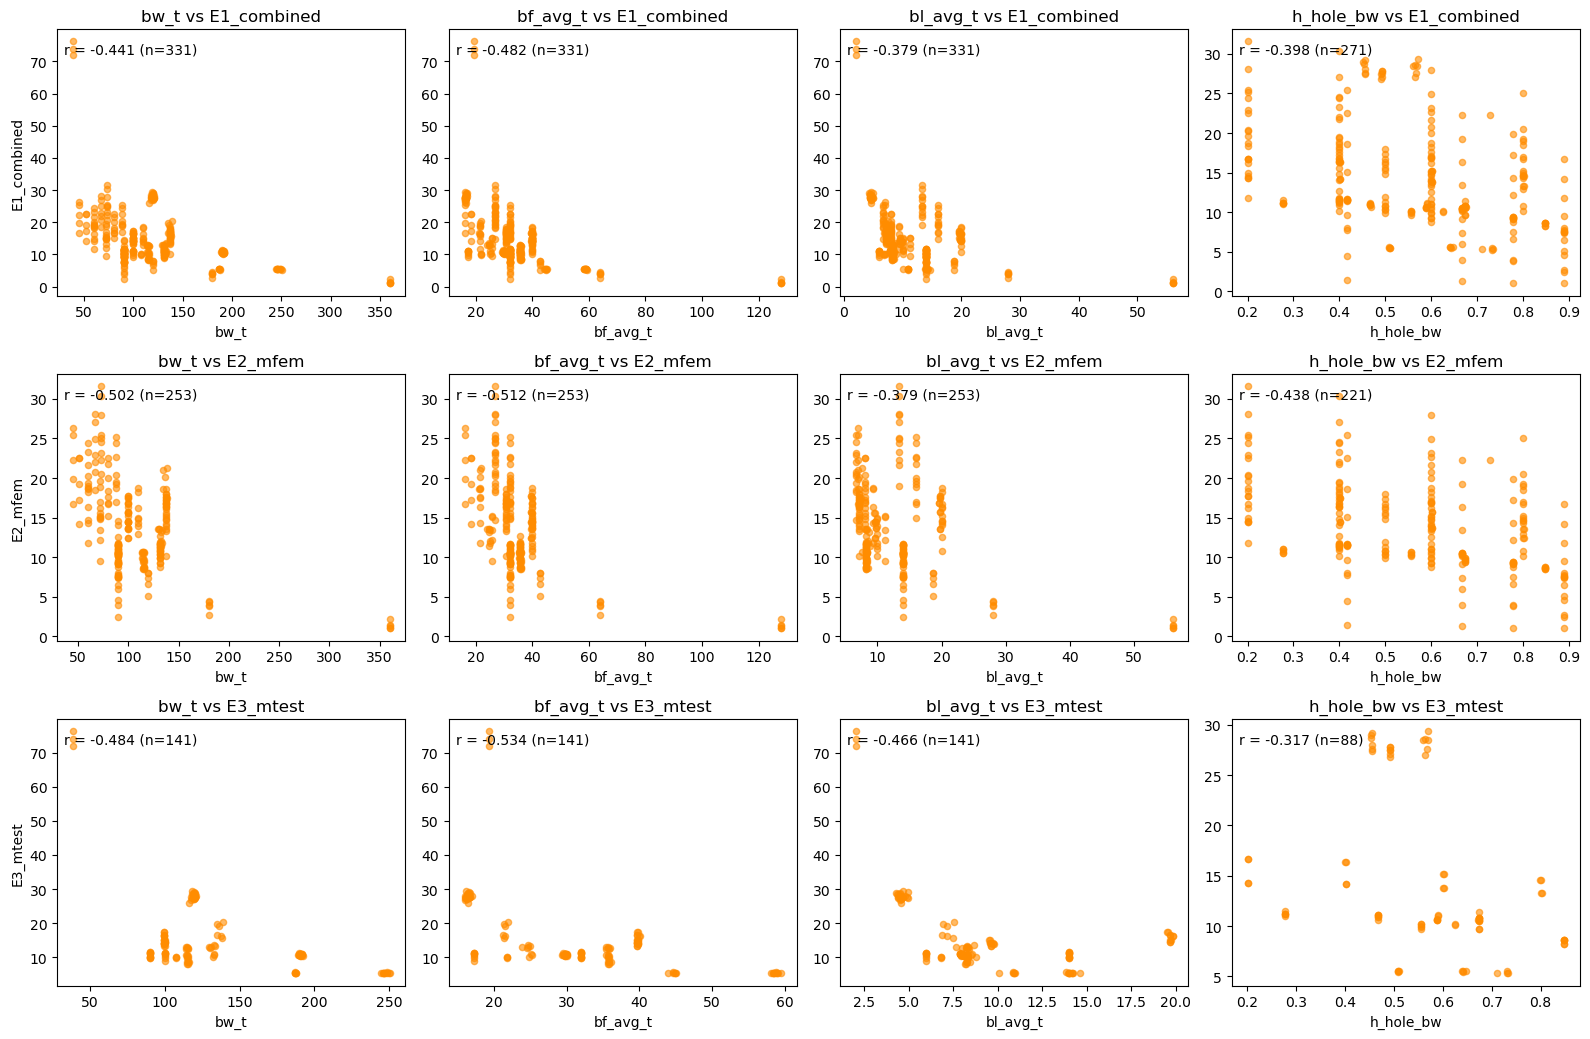

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# We group by geometry_signature to collapse repeated geometries,
# then plot ratio features vs ALL experiment targets (COMBINED, MFEM, MTEST)
# with Pearson r shown on the scatter plots.

if "df_clean" not in globals():
    raise NameError("df_clean not found. Run prior checkpoints first.")

def norm_col(name):
    return "".join(ch for ch in str(name).lower() if ch.isalnum())

def find_col(df, key):
    return next((c for c in df.columns if key in c.lower()), None)

def safe_div(a, b):
    a = pd.to_numeric(a, errors="coerce")
    b = pd.to_numeric(b, errors="coerce")
    out = a / b
    out[(b == 0) | b.isna()] = np.nan
    return out

def safe_corr(x, y):
    x = pd.Series(x)
    y = pd.Series(y)
    m = x.notna() & y.notna()
    if m.sum() < 2:
        return np.nan
    return float(np.corrcoef(x[m], y[m])[0, 1])

df_base = df_clean.copy()

# Targets
mtest_col = find_col(df_base, "mtest")
mfem_col = find_col(df_base, "mfem")
if mtest_col is None or mfem_col is None:
    raise ValueError("MTEST/MFEM columns not found.")

df_base[mtest_col] = pd.to_numeric(df_base[mtest_col], errors="coerce")
df_base[mfem_col] = pd.to_numeric(df_base[mfem_col], errors="coerce")
df_base["COMBINED"] = df_base[mtest_col].where(df_base[mtest_col].notna(), df_base[mfem_col])

# Build geometry_signature from base features (name-based drop)
drop_keys = {
    "slno", "journaltitle", "specimen", "shapecode",
    "boundarycondition", "loadingcondition",
    "failuremode", "aisi", "eurocode3", "asnzs",
    "q",
}
drop_cols = [c for c in df_base.columns if norm_col(c) in drop_keys]
exclude = set(drop_cols + [mtest_col, mfem_col, "COMBINED", "y", "y_combined", "geometry_signature"])
feature_cols = [c for c in df_base.columns if c not in exclude]

sig_df = df_base[feature_cols].copy()
for c in sig_df.columns:
    if pd.api.types.is_numeric_dtype(sig_df[c]):
        sig_df[c] = sig_df[c].fillna(-999999)
    else:
        sig_df[c] = sig_df[c].fillna("MISSING").astype(str)

df_base["geometry_signature"] = pd.util.hash_pandas_object(sig_df, index=False).astype("int64")

# Ratio features
cols_norm = {norm_col(c): c for c in df_base.columns}
bw_col = cols_norm.get("bw")
t_col = cols_norm.get("t")
bfavg_col = cols_norm.get("bfavg")
blavg_col = cols_norm.get("blavg")
hhole_col = cols_norm.get("hhole")

ratio_data = {}
if bw_col and t_col:
    ratio_data["bw_t"] = safe_div(df_base[bw_col], df_base[t_col])
if bfavg_col and t_col:
    ratio_data["bf_avg_t"] = safe_div(df_base[bfavg_col], df_base[t_col])
if blavg_col and t_col:
    ratio_data["bl_avg_t"] = safe_div(df_base[blavg_col], df_base[t_col])
if hhole_col and bw_col:
    ratio_data["h_hole_bw"] = safe_div(df_base[hhole_col], df_base[bw_col])

if not ratio_data:
    raise ValueError("No ratio features could be computed (missing columns).")

ratio_df = pd.DataFrame(ratio_data, index=df_base.index)

# Group by geometry_signature to reduce duplicate geometries
analysis_df = pd.concat(
    [ratio_df, df_base[["COMBINED", mtest_col, mfem_col, "geometry_signature"]]],
    axis=1
)
grouped = analysis_df.groupby("geometry_signature").mean()

print(f"Grouped geometries: {grouped.shape[0]} (from {df_base.shape[0]} rows)")
print("Ratios available:", list(ratio_data.keys()))

# Plot ratios vs all targets
targets = [("COMBINED", "E1_combined"), (mfem_col, "E2_mfem"), (mtest_col, "E3_mtest")]
ratios = list(ratio_data.keys())

fig, axes = plt.subplots(len(targets), len(ratios), figsize=(4 * len(ratios), 3.5 * len(targets)), squeeze=False)

for i, (tcol, tlabel) in enumerate(targets):
    for j, rname in enumerate(ratios):
        ax = axes[i, j]
        x = grouped[rname]
        y = grouped[tcol]
        m = x.notna() & y.notna()
        r = safe_corr(x[m], y[m])

        ax.scatter(x[m], y[m], alpha=0.6, s=20, color="darkorange")
        ax.set_xlabel(rname)
        ax.set_ylabel(tlabel if j == 0 else "")
        ax.set_title(f"{rname} vs {tlabel}")
        ax.text(0.02, 0.95, f"r = {r:.3f} (n={m.sum()})", transform=ax.transAxes, va="top")

plt.tight_layout()
plt.show()


### Ratio Feature Diagnostics (No Model Fit)
Across grouped geometries, the engineered ratios show **consistent negative associations** with buckling strength for all three targets (Combined, MFEM, MTEST). The strongest effects come from **bw/t**, **bf_avg/t**, and **bl_avg/t** (r ≈ −0.32 to −0.53), indicating that **greater slenderness (larger width or flange dimensions relative to thickness)** reduces strength — a physically expected trend. The **h_hole/bw** ratio also shows a moderate negative correlation (r ≈ −0.32 to −0.37), suggesting that **larger hole height relative to width** weakens buckling capacity. These ratios were analyzed **purely as diagnostics** (no model fitting), so they serve as **supporting evidence** for geometry-driven behavior rather than a learned performance gain.



# Concluding Story: Buckling Strength ML (Minimal FE)

## What worked best
- Across all three experiments (combined, MFEM-only, MTEST-only), **tree models consistently outperformed linear models** on MAE after leakage-safe GroupKFold validation.  
- A small hyperparameter search improved GradientBoosting further, giving the best overall results in each experiment.

## Key drivers (features that matter most)
Across linear standardized coefficients and tree permutation importance, a **stable core set of drivers** emerged:
- **Thickness (t)** and **width (bw)**: the most consistent and strongest predictors.
- **Hole geometry** (r/h/l hole) and **hole position/spacing** (distance from top/left to first hole; spacing Sx) are critical.
- **bf_avg / bl_avg** capture flange geometry with minimal feature engineering and remain important.
- **HOLE SHAPE** and missingness indicators for hole fields carry meaningful signal (e.g., no‑hole vs hole configurations).

## MFEM vs MTEST differences
- **MFEM-only (E2)** emphasizes geometry (bw, t, bl_avg) and hole dimensions/position; material strength still matters but slightly less.  
- **MTEST-only (E3)** shows stronger sensitivity to **hole position/spacing** and some material properties, suggesting experimental outcomes are more affected by geometry placement and boundary variations.

## Validation and reliability
- We used **GroupKFold with a geometry_signature** to avoid leakage from repeated/near-duplicate specimens.  
- Predicted vs actual plots show strong alignment; residuals are centered with a few outliers, which is expected in heterogeneous experimental data.

## Limitations
- The **slot (elongated) hole shape is missing in E3**, so MTEST-only models should not be used for slot predictions.  
- Some importance is carried by missingness indicators, implying that **structural missingness encodes real design choices** (e.g., hole presence/absence).  
- Performance on rare configurations may be less reliable due to limited samples.

## Next steps
- **Feature importance deep dive**: quantify how overlapping top‑k features align with domain expectations.  
- **Error analysis by hole shape and journal/source** to identify systematic weaknesses.  
- Optionally explore **domain ratio features** (bw/t, bf/t, bl/t, h_hole/bw) as a separate add‑on section to test physics‑informed gains.



# Final Conclusions (Bullet Summary)

- **Best overall models**: GradientBoosting consistently delivers the lowest MAE across E1/E2/E3; linear models are close but slightly weaker.
- **Robust validation**: Geometry‑based GroupKFold reduces leakage risk; strong predicted‑vs‑actual alignment and centered residuals support model reliability.
- **Core drivers are stable**: Thickness (t), width (bw), hole geometry (r/h/l), and hole position (distance to first hole, spacing) dominate across experiments.
- **MFEM vs MTEST differences**: MFEM is more geometry‑dominated; MTEST shows stronger sensitivity to hole placement/spacing and some material properties.
- **Hole‑shape coverage matters**: E3 (MTEST‑only) lacks slot cases → avoid extrapolating MTEST models to slot geometries.
- **Minimal FE is sufficient**: bf_avg/bl_avg retain strong signal; no complex ratios required for baseline performance.
- **Ratio diagnostics (no model fit)**: bw/t, bf_avg/t, bl_avg/t, and h_hole/bw show consistent negative associations with targets, reinforcing slenderness and hole‑size effects.
- **Residual structure**: Errors cluster around zero with a few outliers, likely from heterogeneous sources or rare configurations.

## Practical takeaways
- Geometry and hole placement are the most reliable levers for buckling strength predictions.  
- Tree models capture nonlinear interactions that linear models miss, but gains are modest, not drastic.

## Next steps
- Add **error stratification** by journal/source and hole shape for operational risk.
- Consider a **ratio‑feature sensitivity add‑on** as a physics‑informed analysis (not required for baseline).
- If expanding the dataset, prioritize **missing shapes** (slot for MTEST) to improve generalization.
